# Config

In [ ]:
!pip install pyspark

# ! pip install pmdarima
# !pip install sktime
# !pip install auto_ts
# !pip install prophet
# !pip install -qqq greykite

!pip install ipython-autotime
%load_ext autotime
# %unload_ext autotime

# Install ipython-sql
!pip install ipython-sql
%load_ext sql
# # Execute SQL commands to create a table, insert data, and run a query
# %%sql
# CREATE TABLE test_table(name, age);
# INSERT INTO test_table VALUES('Alice', 24);
# SELECT * FROM test_table;

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=84bbc65acf388868c961120fb61c111154a789bb9faf0b9a7db94507713c4d2d
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.6 MB/s eta 0:00:00
time: 7.67 s (started: 2024-05-05 06:51:19 +00:00)


In [ ]:
import pyspark
import pyspark.sql as pyspark_sql
import pyspark.sql.types as T
import pyspark.sql.functions  as F
from pyspark.sql.window import Window
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, DataFrame
import pyspark.pandas as ps

/usr/local/lib/python3.10/dist-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


time: 414 ms (started: 2024-05-05 06:51:27 +00:00)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import os
import warnings
warnings.filterwarnings("ignore")

from dateutil.relativedelta import relativedelta
from scipy.stats import linregress
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from tqdm import tqdm
from datetime import datetime
import math

time: 1.48 s (started: 2024-05-05 06:51:27 +00:00)


In [ ]:
# ps.set_option('display.max_columns', None)
# ps.set_option('compute.ops_on_diff_frames', True)
# ps.set_option('display.max_rows', 60)

spark = SparkSession.builder.master("local[*]")\
        .getOrCreate()
        # .config(conf = SparkConf().setAll([("spark.scheduler.mode","FAIR")]))\

windowSpec  = Window.partitionBy("DEPARTMENT").orderBy("SALARY")

spark

time: 14.6 s (started: 2024-05-05 06:51:29 +00:00)


In [ ]:
# spark.sparkContext.getConf().getAll()
spark.conf.set(
    "spark.sql.execution.arrow.pyspark.fallback.enabled", "true"
)

time: 12.8 ms (started: 2024-05-05 06:51:43 +00:00)


# Load data

In [ ]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

! kaggle competitions download -c m5-forecasting-accuracy

! unzip m5-forecasting-accuracy.zip

 87% 40.0M/45.8M [00:00<00:00, 90.3MB/s]
100% 45.8M/45.8M [00:00<00:00, 83.9MB/s]
Archive:  m5-forecasting-accuracy.zip
  inflating: calendar.csv            
  inflating: sales_train_evaluation.csv  
  inflating: sales_train_validation.csv  
  inflating: sample_submission.csv   
  inflating: sell_prices.csv         
time: 24.6 s (started: 2024-03-15 10:13:57 +00:00)


In [ ]:
df_calendar = spark.read.format("csv").options(header = True, delimeter = ";").load("/content/calendar.csv")
df_price = spark.read.format("csv").options(header = True, delimeter = ";").load("/content/sell_prices.csv")
df_product = spark.read.format("csv").options(header = True, delimeter = ";").load("/content/sales_train_evaluation.csv")

# this file is format of M5 competition -> not usable
# df_train_val = ps.read_csv("/content/sales_train_validation.csv")
# df_sampe_submission = pd.read_csv("/content/sample_submission.csv")

time: 20 s (started: 2024-03-15 11:20:51 +00:00)


# Data preprocessing

## product data

In [ ]:
print(df_product.count(), len(df_product.columns))
df_product.show(5)

30490 1947
+--------------------+-------------+---------+-------+--------+--------+---+---+---+---+---+---+---+---+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----

In [ ]:
df_product = df_product.dropDuplicates()

time: 437 ms (started: 2024-03-15 11:21:11 +00:00)


In [ ]:
key_product = ["id","item_id","dept_id","cat_id","store_id","state_id"]
index_product = [col for col in df_product.columns if col not in key_product]
key_product, len(index_product)

(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], 1941)

time: 116 ms (started: 2024-03-15 11:21:11 +00:00)


In [ ]:
df_product = df_product.melt(ids = key_product, values = index_product,\
                             variableColumnName="d", valueColumnName = "sell")

time: 3.82 s (started: 2024-03-15 11:21:11 +00:00)


In [ ]:
print(df_product.count(), len(df_product.columns))
df_product.show(5)

59181090 8
+--------------------+-------------+---------+-------+--------+--------+---+----+
|                  id|      item_id|  dept_id| cat_id|store_id|state_id|  d|sell|
+--------------------+-------------+---------+-------+--------+--------+---+----+
|HOBBIES_1_217_TX_...|HOBBIES_1_217|HOBBIES_1|HOBBIES|    TX_1|      TX|d_1|   0|
|HOBBIES_1_217_TX_...|HOBBIES_1_217|HOBBIES_1|HOBBIES|    TX_1|      TX|d_2|   0|
|HOBBIES_1_217_TX_...|HOBBIES_1_217|HOBBIES_1|HOBBIES|    TX_1|      TX|d_3|   0|
|HOBBIES_1_217_TX_...|HOBBIES_1_217|HOBBIES_1|HOBBIES|    TX_1|      TX|d_4|   0|
|HOBBIES_1_217_TX_...|HOBBIES_1_217|HOBBIES_1|HOBBIES|    TX_1|      TX|d_5|   0|
+--------------------+-------------+---------+-------+--------+--------+---+----+
only showing top 5 rows

time: 4min 15s (started: 2024-03-12 03:36:42 +00:00)


- There is one column each for the IDs of item, department, category, store, and state; plus a general ID that is a combination of the other IDs plus a flag for validation.

- The sales per date are encoded as columns starting with the prefix d_. Those are the number of units sold per day (not the total amount of dollars).

- Data is quite a lot of zero values.

## price product

In [ ]:
print(df_price.count(), len(df_price.columns))
df_price.show(5, truncate = True)

6841121 4
+--------+-------------+--------+----------+
|store_id|      item_id|wm_yr_wk|sell_price|
+--------+-------------+--------+----------+
|    CA_1|HOBBIES_1_001|   11325|      9.58|
|    CA_1|HOBBIES_1_001|   11326|      9.58|
|    CA_1|HOBBIES_1_001|   11327|      8.26|
|    CA_1|HOBBIES_1_001|   11328|      8.26|
|    CA_1|HOBBIES_1_001|   11329|      8.26|
+--------+-------------+--------+----------+
only showing top 5 rows

time: 3.12 s (started: 2024-03-12 03:12:34 +00:00)


In [ ]:
df_price.where(F.col('sell_price').isNull()).show()

+--------+-------+--------+----------+
|store_id|item_id|wm_yr_wk|sell_price|
+--------+-------+--------+----------+
+--------+-------+--------+----------+

time: 12.8 s (started: 2024-03-12 03:22:57 +00:00)


In [ ]:
df_price.select([F.count(F.when(F.isnan(c), c)).alias(c) for c in df_price.columns]).show()

+--------+-------+--------+----------+
|store_id|item_id|wm_yr_wk|sell_price|
+--------+-------+--------+----------+
|       0|      0|       0|         0|
+--------+-------+--------+----------+

time: 58.5 s (started: 2024-03-12 03:19:15 +00:00)


In [ ]:
df_price = df_price.withColumn("sell_price", df_price["sell_price"].cast(T.FloatType()))
df_price.printSchema()

root
 |-- store_id: string (nullable = true)
 |-- item_id: string (nullable = true)
 |-- wm_yr_wk: string (nullable = true)
 |-- sell_price: float (nullable = true)

time: 60.7 ms (started: 2024-03-15 10:15:19 +00:00)


In [ ]:
df_price.filter(~df_price["store_id"].isin(df_product.select("store_id").distinct().rdd.flatMap(lambda x: x).collect())).show()

+--------+-------+--------+----------+
|store_id|item_id|wm_yr_wk|sell_price|
+--------+-------+--------+----------+
+--------+-------+--------+----------+

time: 3min 5s (started: 2024-03-12 03:57:08 +00:00)


In [ ]:
df_product.filter(~df_product["store_id"].isin(df_price.select("store_id").distinct().rdd.flatMap(lambda x: x).collect())).show()

+---+-------+-------+------+--------+--------+---+----+
| id|item_id|dept_id|cat_id|store_id|state_id|  d|sell|
+---+-------+-------+------+--------+--------+---+----+
+---+-------+-------+------+--------+--------+---+----+

time: 22.2 s (started: 2024-03-12 03:52:04 +00:00)


In [ ]:
df_product.filter(~df_product["item_id"].isin(df_price.select("item_id").distinct().rdd.flatMap(lambda x: x).collect())).show()

+---+-------+-------+------+--------+--------+---+----+
| id|item_id|dept_id|cat_id|store_id|state_id|  d|sell|
+---+-------+-------+------+--------+--------+---+----+
+---+-------+-------+------+--------+--------+---+----+

time: 32 s (started: 2024-03-12 04:00:16 +00:00)


Wrap up:

- Price of product are correct
- All of product have there own price, not missing any price of product
- We have the store_id and item_id to link this data to our training and validation data.
- Prices range from $0.10 to a bit more than 100 dollars.

## calendar master

In [ ]:
print(df_calendar.count(), len(df_calendar.columns))
display(df_calendar.show(5))
display(df_calendar.describe().show())

1969 14
+----------+--------+---------+----+-----+----+---+------------+------------+------------+------------+-------+-------+-------+
|      date|wm_yr_wk|  weekday|wday|month|year|  d|event_name_1|event_type_1|event_name_2|event_type_2|snap_CA|snap_TX|snap_WI|
+----------+--------+---------+----+-----+----+---+------------+------------+------------+------------+-------+-------+-------+
|2011-01-29|   11101| Saturday|   1|    1|2011|d_1|        NULL|        NULL|        NULL|        NULL|      0|      0|      0|
|2011-01-30|   11101|   Sunday|   2|    1|2011|d_2|        NULL|        NULL|        NULL|        NULL|      0|      0|      0|
|2011-01-31|   11101|   Monday|   3|    1|2011|d_3|        NULL|        NULL|        NULL|        NULL|      0|      0|      0|
|2011-02-01|   11101|  Tuesday|   4|    2|2011|d_4|        NULL|        NULL|        NULL|        NULL|      1|      1|      0|
|2011-02-02|   11101|Wednesday|   5|    2|2011|d_5|        NULL|        NULL|        NULL|      

None

+-------+----------+------------------+---------+------------------+-----------------+------------------+-----+------------+------------+--------------+------------+-------------------+-------------------+-------------------+
|summary|      date|          wm_yr_wk|  weekday|              wday|            month|              year|    d|event_name_1|event_type_1|  event_name_2|event_type_2|            snap_CA|            snap_TX|            snap_WI|
+-------+----------+------------------+---------+------------------+-----------------+------------------+-----+------------+------------+--------------+------------+-------------------+-------------------+-------------------+
|  count|      1969|              1969|     1969|              1969|             1969|              1969| 1969|         162|         162|             5|           5|               1969|               1969|               1969|
|   mean|      NULL|11347.086338242763|     NULL|3.9974606399187405|6.325545962417471| 2013.2884

None

time: 10.1 s (started: 2024-03-14 04:42:36 +00:00)


In [ ]:
df_calendar.select(["date","d"]).show(20)

+----------+----+
|      date|   d|
+----------+----+
|2011-01-29| d_1|
|2011-01-30| d_2|
|2011-01-31| d_3|
|2011-02-01| d_4|
|2011-02-02| d_5|
|2011-02-03| d_6|
|2011-02-04| d_7|
|2011-02-05| d_8|
|2011-02-06| d_9|
|2011-02-07|d_10|
|2011-02-08|d_11|
|2011-02-09|d_12|
|2011-02-10|d_13|
|2011-02-11|d_14|
|2011-02-12|d_15|
|2011-02-13|d_16|
|2011-02-14|d_17|
|2011-02-15|d_18|
|2011-02-16|d_19|
|2011-02-17|d_20|
+----------+----+
only showing top 20 rows

time: 482 ms (started: 2024-03-14 04:42:47 +00:00)


In [ ]:
# check  gap date of calendar
temp = df_calendar.select("*")
temp.printSchema()

root
 |-- date: string (nullable = true)
 |-- wm_yr_wk: string (nullable = true)
 |-- weekday: string (nullable = true)
 |-- wday: string (nullable = true)
 |-- month: string (nullable = true)
 |-- year: string (nullable = true)
 |-- d: string (nullable = true)
 |-- event_name_1: string (nullable = true)
 |-- event_type_1: string (nullable = true)
 |-- event_name_2: string (nullable = true)
 |-- event_type_2: string (nullable = true)
 |-- snap_CA: string (nullable = true)
 |-- snap_TX: string (nullable = true)
 |-- snap_WI: string (nullable = true)

time: 23 ms (started: 2024-03-14 05:21:35 +00:00)


In [ ]:
temp = temp.withColumn("date", F.col("date").cast(T.DateType()))\
            .withColumn("timestamp", F.col("date").cast(T.TimestampType()).cast("long"))

time: 63.1 ms (started: 2024-03-14 05:22:33 +00:00)


In [ ]:
window_spec = Window.orderBy("date")

time: 12.4 ms (started: 2024-03-14 05:23:00 +00:00)


In [ ]:
temp = temp.withColumn("lag_1", F.lag("timestamp", offset = 1).over(window_spec))

time: 84.9 ms (started: 2024-03-14 05:24:07 +00:00)


In [ ]:
temp.withColumn("gap_date", (F.col("timestamp") - F.col("lag_1")) / (60*60*24)).describe().show()

+-------+------------------+---------+------------------+-----------------+------------------+-----+------------+------------+--------------+------------+-------------------+-------------------+-------------------+-------------------+--------------------+--------+
|summary|          wm_yr_wk|  weekday|              wday|            month|              year|    d|event_name_1|event_type_1|  event_name_2|event_type_2|            snap_CA|            snap_TX|            snap_WI|          timestamp|               lag_1|gap_date|
+-------+------------------+---------+------------------+-----------------+------------------+-----+------------+------------+--------------+------------+-------------------+-------------------+-------------------+-------------------+--------------------+--------+
|  count|              1969|     1969|              1969|             1969|              1969| 1969|         162|         162|             5|           5|               1969|               1969|           

In [ ]:
temp.groupby(["weekday","wday"]).count().show()
# seems to be weekday encode to wday with start index at Saturday
# keep in mind this when we use wday column for both

+---------+----+-----+
|  weekday|wday|count|
+---------+----+-----+
|  Tuesday|   4|  281|
|   Sunday|   2|  282|
|   Friday|   7|  281|
|Wednesday|   5|  281|
|   Monday|   3|  281|
| Thursday|   6|  281|
| Saturday|   1|  282|
+---------+----+-----+

time: 1.2 s (started: 2024-03-14 05:51:47 +00:00)


In [ ]:
temp = temp.withColumn("wm_yr_wk", F.col("wm_yr_wk").cast(T.FloatType()))
temp = temp.withColumn("wm_yr_wk_123", F.col("wm_yr_wk") / 100)\
            .withColumn("wm_yr_wk_45", F.col("wm_yr_wk") % 100)
temp.select(["wm_yr_wk_123", "wm_yr_wk_45"]).describe().show()
# first 2 numbers of wm_yr_wk is const = 11
# 3rd number is a year index
# last 2 numbers is week of year index

+-------+------------------+------------------+
|summary|      wm_yr_wk_123|       wm_yr_wk_45|
+-------+------------------+------------------+
|  count|              1969|              1969|
|   mean|113.47086338242768| 25.45099035043169|
| stddev|1.5527704280285317|15.176125890259353|
|    min|            111.01|               1.0|
|    max|            116.21|              53.0|
+-------+------------------+------------------+

time: 2.9 s (started: 2024-03-14 05:58:20 +00:00)


In [ ]:
df_calendar.groupby(["event_type_1","event_name_1"]).count().sort("event_type_1").show()

+------------+-------------------+-----+
|event_type_1|       event_name_1|count|
+------------+-------------------+-----+
|        NULL|               NULL| 1807|
|    Cultural|      ValentinesDay|    6|
|    Cultural|             Easter|    5|
|    Cultural|       Mother's day|    6|
|    Cultural|       Father's day|    4|
|    Cultural|      StPatricksDay|    6|
|    Cultural|          Halloween|    5|
|    Cultural|      Cinco De Mayo|    5|
|    National|            NewYear|    5|
|    National|          Christmas|    5|
|    National|    IndependenceDay|    5|
|    National|       Thanksgiving|    5|
|    National|      PresidentsDay|    6|
|    National|        ColumbusDay|    5|
|    National|        MemorialDay|    6|
|    National|           LaborDay|    5|
|    National|MartinLutherKingDay|    5|
|    National|        VeteransDay|    5|
|   Religious|     Ramadan starts|    6|
|   Religious|  OrthodoxChristmas|    5|
+------------+-------------------+-----+
only showing top

In [ ]:
df_calendar.groupby(["event_type_2","event_name_2"]).count().sort("event_type_2").show()

+------------+--------------+-----+
|event_type_2|  event_name_2|count|
+------------+--------------+-----+
|        NULL|          NULL| 1964|
|    Cultural|        Easter|    1|
|    Cultural|  Father's day|    2|
|    Cultural| Cinco De Mayo|    1|
|   Religious|OrthodoxEaster|    1|
+------------+--------------+-----+

time: 809 ms (started: 2024-03-14 06:00:37 +00:00)


In [ ]:
df_calendar.groupby(["snap_CA","snap_TX","snap_WI"]).count().orderBy(["snap_CA","snap_TX","snap_WI"]).show()

+-------+-------+-------+-----+
|snap_CA|snap_TX|snap_WI|count|
+-------+-------+-------+-----+
|      0|      0|      0|  994|
|      0|      0|      1|   65|
|      0|      1|      0|   65|
|      0|      1|      1|  195|
|      1|      0|      0|  130|
|      1|      0|      1|  130|
|      1|      1|      0|  130|
|      1|      1|      1|  260|
+-------+-------+-------+-----+

time: 702 ms (started: 2024-03-14 06:03:09 +00:00)


In [ ]:
# df_calendar["date"] = pd.to_datetime(df_calendar["date"], format = "%Y-%m-%d")
# df_calendar = df_calendar.drop(["weekday","wm_yr_wk"], axis = 1)
# df_calendar.columns = ["DATE","WDAY","MONTH","YEAR","TIME_INDEX","EVENT_NAME_1","EVENT_TYPE_1",""]

Wrap up:

- Totally, calendar master data clean about logic datetime transformation
- Datetime transformation using isocalendar => no need to use column "d", "wm_yr_wk" from original data, we can agument product data later
- "Weekday" column encode ordinally to "wday" with start index 1 as Saturday and end index 7 as Friday
- Event_name are unique in each event_type and not duplicated among event_type
- "snap_CA","snap_TX","snap_WI" are binary data present for California (CA), Texas (TX), and Wisconsin (WI)
- The calendar has all the relevant dates, weekdays, months plus snap binary flags and logical event columns.
- There are only 5 non-NA rows in the event_name_2 column; i.e. only 5 (out of 1969) instances where there is more than 1 event on a particular day.

## Main data

In [ ]:
df_product = df_product.join(df_calendar, df_product["d"] == df_calendar["d"], how = "left").drop(df_calendar["d"])

time: 208 ms (started: 2024-03-15 11:21:15 +00:00)


In [ ]:
df_product = df_product.join(
    df_price,
    (df_product["store_id"] == df_price["store_id"])
    & (df_product["item_id"] == df_price["item_id"])
    & (df_product["wm_yr_wk"] == df_price["wm_yr_wk"]),
    how = "left"
).drop(*df_price["store_id","item_id","wm_yr_wk"])

time: 276 ms (started: 2024-03-15 11:39:02 +00:00)


In [ ]:
df_product.printSchema()

root
 |-- id: string (nullable = true)
 |-- item_id: string (nullable = true)
 |-- dept_id: string (nullable = true)
 |-- cat_id: string (nullable = true)
 |-- store_id: string (nullable = true)
 |-- state_id: string (nullable = true)
 |-- d: string (nullable = false)
 |-- sell: string (nullable = true)
 |-- date: string (nullable = true)
 |-- wm_yr_wk: string (nullable = true)
 |-- weekday: string (nullable = true)
 |-- wday: string (nullable = true)
 |-- month: string (nullable = true)
 |-- year: string (nullable = true)
 |-- event_name_1: string (nullable = true)
 |-- event_type_1: string (nullable = true)
 |-- event_name_2: string (nullable = true)
 |-- event_type_2: string (nullable = true)
 |-- snap_CA: string (nullable = true)
 |-- snap_TX: string (nullable = true)
 |-- snap_WI: string (nullable = true)
 |-- sell_price: string (nullable = true)

time: 6.54 ms (started: 2024-03-15 11:39:23 +00:00)


In [ ]:
df_product = df_product.select(
    F.col("id").alias("ID"),
    F.col("item_id").alias("ITEM"),
    F.col("dept_id").alias("DEPARTMENT"),
    F.col("cat_id").alias("CATEGORY"),
    F.col("store_id").alias("STORE"),
    F.col("state_id").alias("STATE"),
    F.col("sell").cast("float").alias("SELL"),
    F.col("sell_price").cast("float").alias("SELL_PRICE"),
    # F.col("d").cast("int").alias("DATE_INDEX_ITEM"),
    F.to_date(F.col("date")).alias("DATE"),
    # F.col("wm_yr_wk").alias("WM_YW"),
    F.col("weekday").alias("WEEK_DAY"),
    F.col("wday").cast("int").alias("DAY_OF_WEEK"),
    F.col("month").cast("int").alias("MONTH"),
    F.col("year").cast("int").alias("YEAR"),
    F.col("event_name_1").alias("EVENT_NAME_1"),
    F.col("event_type_1").alias("EVENT_TYPE_1"),
    F.col("event_name_2").alias("EVENT_NAME_2"),
    F.col("event_type_2").alias("EVENT_TYPE_2"),
    F.col("snap_CA").cast("int").alias("SNAP_CA"),
    F.col("snap_TX").cast("int").alias("SNAP_TX"),
    F.col("snap_WI").cast("int").alias("SNAP_WI"),
).orderBy(*["ID","ITEM","STORE","DATE"])

time: 440 ms (started: 2024-03-15 12:09:38 +00:00)


In [ ]:
print(df_product.count(), len(df_product.columns))
df_product.show(5, truncate = False)

59181090 21
+---------------------------+-----------+----------+--------+-----+-----+----+----------+---------------+----------+---------+-----------+-----+----+------------+------------+------------+------------+-------+-------+-------+
|ID                         |ITEM       |DEPARTMENT|CATEGORY|STORE|STATE|SELL|SELL_PRICE|DATE_INDEX_ITEM|DATE      |WEEK_DAY |DAY_OF_WEEK|MONTH|YEAR|EVENT_NAME_1|EVENT_TYPE_1|EVENT_NAME_2|EVENT_TYPE_2|SNAP_CA|SNAP_TX|SNAP_WI|
+---------------------------+-----------+----------+--------+-----+-----+----+----------+---------------+----------+---------+-----------+-----+----+------------+------------+------------+------------+-------+-------+-------+
|FOODS_1_001_CA_1_evaluation|FOODS_1_001|FOODS_1   |FOODS   |CA_1 |CA   |3.0 |2.0       |NULL           |2011-01-29|Saturday |1          |1    |2011|NULL        |NULL        |NULL        |NULL        |0      |0      |0      |
|FOODS_1_001_CA_1_evaluation|FOODS_1_001|FOODS_1   |FOODS   |CA_1 |CA   |0.0 |2.0   

In [ ]:
df_product.select("ITEM").distinct().count()

3049

time: 7min 53s (started: 2024-03-15 12:49:12 +00:00)


In [ ]:
df_product.write.format("csv").mode('overwrite').save("/content/preprocess_data.csv", header = True)

time: 35min 22s (started: 2024-03-15 13:08:03 +00:00)


In [ ]:
import shutil
shutil.make_archive("/content/preprocess_data", 'zip', "/content/preprocess_data.csv")

In [ ]:
import zipfile
with zipfile.ZipFile("/content/drive/MyDrive/Capstone project m5 forecast/preprocess_data.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/data/")

df_product = spark.read.option("header","true").format("csv").load("/content/data/")

time: 1min 21s (started: 2024-05-05 06:53:20 +00:00)


In [ ]:
df_product = df_product.withColumn("SELL", F.col("SELL").cast("float"))\
                       .withColumn("SELL_PRICE", F.col("SELL_PRICE").cast("float"))\
                       .withColumn("DATE_INDEX_ITEM", F.col("DATE_INDEX_ITEM").cast("int"))\
                       .withColumn("DATE", F.to_date(F.col("date")))\
                       .withColumn("DAY_OF_WEEK", F.col("DAY_OF_WEEK").cast("int"))\
                       .withColumn("MONTH", F.col("MONTH").cast("int"))\
                       .withColumn("YEAR", F.col("YEAR").cast("int"))\
                       .withColumn("SNAP_CA", F.col("SNAP_CA").cast("int"))\
                       .withColumn("SNAP_TX", F.col("SNAP_TX").cast("int"))\
                       .withColumn("SNAP_WI", F.col("SNAP_WI").cast("int"))\
                       .orderBy("ID","ITEM","STORE","DATE")

df_product.printSchema()

root
 |-- ID: string (nullable = true)
 |-- ITEM: string (nullable = true)
 |-- DEPARTMENT: string (nullable = true)
 |-- CATEGORY: string (nullable = true)
 |-- STORE: string (nullable = true)
 |-- STATE: string (nullable = true)
 |-- SELL: float (nullable = true)
 |-- SELL_PRICE: float (nullable = true)
 |-- DATE_INDEX_ITEM: integer (nullable = true)
 |-- DATE: date (nullable = true)
 |-- WEEK_DAY: string (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- YEAR: integer (nullable = true)
 |-- EVENT_NAME_1: string (nullable = true)
 |-- EVENT_TYPE_1: string (nullable = true)
 |-- EVENT_NAME_2: string (nullable = true)
 |-- EVENT_TYPE_2: string (nullable = true)
 |-- SNAP_CA: integer (nullable = true)
 |-- SNAP_TX: integer (nullable = true)
 |-- SNAP_WI: integer (nullable = true)

time: 1.25 s (started: 2024-05-05 06:54:42 +00:00)


In [ ]:
df_top_product = df_product.groupBy(
    "STATE","STORE","DEPARTMENT","CATEGORY","ITEM","ID",
).sum("SELL").orderBy(["sum(SELL)"], ascending = False)

df_top_product.show(5)

+-----+-----+----------+--------+-----------+--------------------+---------+
|STATE|STORE|DEPARTMENT|CATEGORY|       ITEM|                  ID|sum(SELL)|
+-----+-----+----------+--------+-----------+--------------------+---------+
|   CA| CA_3|   FOODS_3|   FOODS|FOODS_3_090|FOODS_3_090_CA_3_...| 253859.0|
|   TX| TX_2|   FOODS_3|   FOODS|FOODS_3_586|FOODS_3_586_TX_2_...| 195120.0|
|   TX| TX_3|   FOODS_3|   FOODS|FOODS_3_586|FOODS_3_586_TX_3_...| 151862.0|
|   CA| CA_3|   FOODS_3|   FOODS|FOODS_3_586|FOODS_3_586_CA_3_...| 136269.0|
|   CA| CA_1|   FOODS_3|   FOODS|FOODS_3_090|FOODS_3_090_CA_1_...| 128855.0|
+-----+-----+----------+--------+-----------+--------------------+---------+
only showing top 5 rows

time: 16min 59s (started: 2024-05-05 07:09:53 +00:00)


In [ ]:
df = df_product.where(
    F.col("ID").isin(
        df_top_product.select("ID").limit(1000).rdd.flatMap(lambda x: x).collect()
    )
)

time: 16min 6s (started: 2024-05-05 07:26:53 +00:00)


In [ ]:
print(df.count(), len(df.columns))
df.show(5)

In [ ]:
df_sample = df.toPandas()

time: 41min 57s (started: 2024-05-05 07:43:00 +00:00)


In [ ]:
print(df_sample.shape)
df_sample.head(3)

(1941000, 21)


ID         ITEM DEPARTMENT CATEGORY STORE STATE  \
0  FOODS_1_004_CA_1_evaluation  FOODS_1_004    FOODS_1    FOODS  CA_1    CA   
1  FOODS_1_004_CA_1_evaluation  FOODS_1_004    FOODS_1    FOODS  CA_1    CA   
2  FOODS_1_004_CA_1_evaluation  FOODS_1_004    FOODS_1    FOODS  CA_1    CA   

   SELL  SELL_PRICE  DATE_INDEX_ITEM        DATE  ... DAY_OF_WEEK  MONTH  \
0   0.0         NaN              NaN  2011-01-29  ...           1      1   
1   0.0         NaN              NaN  2011-01-30  ...           2      1   
2   0.0         NaN              NaN  2011-01-31  ...           3      1   

   YEAR  EVENT_NAME_1 EVENT_TYPE_1 EVENT_NAME_2 EVENT_TYPE_2 SNAP_CA  SNAP_TX  \
0  2011          None         None         None         None       0        0   
1  2011          None         None         None         None       0        0   
2  2011          None         None         None         None       0        0   

   SNAP_WI  
0        0  
1        0  
2        0  

[3 rows x 21 columns]

time: 63.1 ms (started: 2024-05-05 08:24:57 +00:00)


In [ ]:
# df_sample.to_csv("/content/drive/MyDrive/Capstone project m5 forecast/top1000_product_sample.csv", index = False)

time: 39.3 s (started: 2024-05-05 08:26:15 +00:00)


# EDA

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
time: 35.8 s (started: 2024-05-05 06:51:43 +00:00)


In [ ]:
df_sample = pd.read_csv("/content/drive/MyDrive/Capstone project m5 forecast/top1000_product_sample.csv")
df_sample["DATE"] = pd.to_datetime(df_sample["DATE"])
print(df_sample["DATE"].min(), df_sample["DATE"].max())
df_sample.head()

2011-01-29 00:00:00 2016-05-22 00:00:00


ID         ITEM DEPARTMENT CATEGORY STORE STATE  \
0  FOODS_1_004_CA_1_evaluation  FOODS_1_004    FOODS_1    FOODS  CA_1    CA   
1  FOODS_1_004_CA_1_evaluation  FOODS_1_004    FOODS_1    FOODS  CA_1    CA   
2  FOODS_1_004_CA_1_evaluation  FOODS_1_004    FOODS_1    FOODS  CA_1    CA   
3  FOODS_1_004_CA_1_evaluation  FOODS_1_004    FOODS_1    FOODS  CA_1    CA   
4  FOODS_1_004_CA_1_evaluation  FOODS_1_004    FOODS_1    FOODS  CA_1    CA   

   SELL  SELL_PRICE  DATE_INDEX_ITEM       DATE  ... DAY_OF_WEEK  MONTH  YEAR  \
0   0.0         NaN              NaN 2011-01-29  ...           1      1  2011   
1   0.0         NaN              NaN 2011-01-30  ...           2      1  2011   
2   0.0         NaN              NaN 2011-01-31  ...           3      1  2011   
3   0.0         NaN              NaN 2011-02-01  ...           4      2  2011   
4   0.0         NaN              NaN 2011-02-02  ...           5      2  2011   

   EVENT_NAME_1 EVENT_TYPE_1 EVENT_NAME_2 EVENT_TYPE_2 SNAP_CA  SNAP_TX  \
0           NaN          NaN          NaN          NaN       0        0   
1           NaN          NaN          NaN          NaN       0        0   
2           NaN          NaN          NaN          NaN       0        0   
3           NaN          NaN          NaN          NaN       1        1   
4           NaN          NaN          NaN          NaN       1        0   

   SNAP_WI  
0        0  
1        0  
2        0  
3        0  
4        1  

[5 rows x 21 columns]

time: 10.1 s (started: 2024-05-05 08:35:31 +00:00)


In [ ]:
df_sample.nunique()

ID                 1000
ITEM                261
DEPARTMENT            5
CATEGORY              3
STORE                10
STATE                 3
SELL                417
SELL_PRICE          258
DATE_INDEX_ITEM       0
DATE               1941
WEEK_DAY              7
DAY_OF_WEEK           7
MONTH                12
YEAR                  6
EVENT_NAME_1         30
EVENT_TYPE_1          4
EVENT_NAME_2          4
EVENT_TYPE_2          2
SNAP_CA               2
SNAP_TX               2
SNAP_WI               2
dtype: int64

time: 1.65 s (started: 2024-05-05 08:35:41 +00:00)


In [ ]:
df_sample.describe(include = "all")

ID         ITEM DEPARTMENT CATEGORY    STORE  \
count                       1941000      1941000    1941000  1941000  1941000   
unique                         1000          261          5        3       10   
top     FOODS_1_004_CA_1_evaluation  FOODS_3_080    FOODS_3    FOODS     CA_3   
freq                           1941        19410    1224771  1535331   419256   
mean                            NaN          NaN        NaN      NaN      NaN   
min                             NaN          NaN        NaN      NaN      NaN   
25%                             NaN          NaN        NaN      NaN      NaN   
50%                             NaN          NaN        NaN      NaN      NaN   
75%                             NaN          NaN        NaN      NaN      NaN   
max                             NaN          NaN        NaN      NaN      NaN   
std                             NaN          NaN        NaN      NaN      NaN   

          STATE          SELL    SELL_PRICE  DATE_INDEX_ITEM  \
count   1941000  1.941000e+06  1.822028e+06              0.0   
unique        3           NaN           NaN              NaN   
top          CA           NaN           NaN              NaN   
freq     859863           NaN           NaN              NaN   
mean        NaN  1.139443e+01  1.781088e+00              NaN   
min         NaN  0.000000e+00  5.000000e-02              NaN   
25%         NaN  2.000000e+00  9.700000e-01              NaN   
50%         NaN  8.000000e+00  1.380000e+00              NaN   
75%         NaN  1.500000e+01  2.000000e+00              NaN   
max         NaN  7.630000e+02  2.398000e+01              NaN   
std         NaN  1.553195e+01  1.492377e+00              NaN   

                                 DATE  ...   DAY_OF_WEEK         MONTH  \
count                         1941000  ...  1.941000e+06  1.941000e+06   
unique                            NaN  ...           NaN           NaN   
top                               NaN  ...           NaN           NaN   
freq                              NaN  ...           NaN           NaN   
mean    2013-09-25 00:00:00.000000512  ...  3.997424e+00  6.334879e+00   
min               2011-01-29 00:00:00  ...  1.000000e+00  1.000000e+00   
25%               2012-05-28 00:00:00  ...  2.000000e+00  3.000000e+00   
50%               2013-09-25 00:00:00  ...  4.000000e+00  6.000000e+00   
75%               2015-01-23 00:00:00  ...  6.000000e+00  9.000000e+00   
max               2016-05-22 00:00:00  ...  7.000000e+00  1.200000e+01   
std                               NaN  ...  2.000643e+00  3.439200e+00   

                YEAR  EVENT_NAME_1 EVENT_TYPE_1 EVENT_NAME_2 EVENT_TYPE_2  \
count   1.941000e+06        158000       158000         4000         4000   
unique           NaN            30            4            4            2   
top              NaN     SuperBowl    Religious       Easter     Cultural   
freq             NaN          6000        54000         1000         3000   
mean    2.013249e+03           NaN          NaN          NaN          NaN   
min     2.011000e+03           NaN          NaN          NaN          NaN   
25%     2.012000e+03           NaN          NaN          NaN          NaN   
50%     2.013000e+03           NaN          NaN          NaN          NaN   
75%     2.015000e+03           NaN          NaN          NaN          NaN   
max     2.016000e+03           NaN          NaN          NaN          NaN   
std     1.556975e+00           NaN          NaN          NaN          NaN   

             SNAP_CA       SNAP_TX       SNAP_WI  
count   1.941000e+06  1.941000e+06  1.941000e+06  
unique           NaN           NaN           NaN  
top              NaN           NaN           NaN  
freq             NaN           NaN           NaN  
mean    3.297269e-01  3.297269e-01  3.297269e-01  
min     0.000000e+00  0.000000e+00  0.000000e+00  
25%     0.000000e+00  0.000000e+00  0.000000e+00  
50%     0.000000e+00  0.000000e+00  0.000000e+00  
75%     1.000000e+

time: 4.68 s (started: 2024-05-05 08:35:43 +00:00)


## Visualization

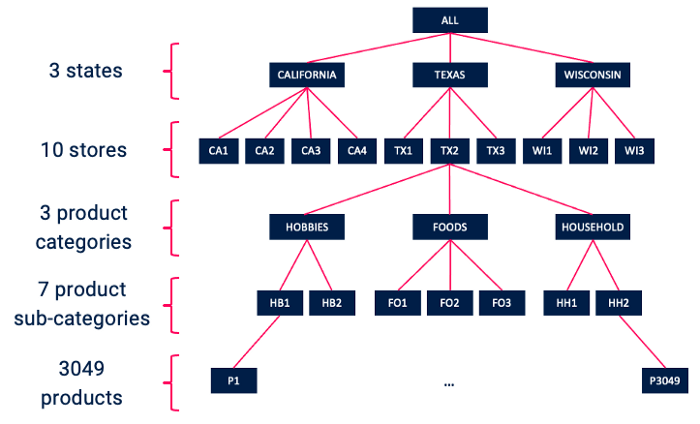

In [ ]:
def plot_timeseries_by_level(
    df: pd.DataFrame,
    key_level = ["ID"],
    target_var = "SELL",
    start_date = "2011-01-01",
    end_date = "2016-05-22",
    hover_mode = "x unified",
    agg_function = "mean",
):
    fig = go.Figure(data= [])

    for key, df_group in df.groupby(key_level):
        df_group = df_group[
            df_group["DATE"].between(start_date, end_date)
        ]
        df_group = df_group.groupby([*key_level,"DATE"]).agg({target_var : agg_function}).reset_index()

        fig.add_trace(
            go.Scatter(
                x = df_group["DATE"],
                y = df_group[target_var],
                name = str(key),
                connectgaps = False,
                mode = "lines",
            )
        )
    # remove square bracket in title
    title_key_level = str(key_level)
    for reg in ["'","[","]"]:
        title_key_level = str(title_key_level).replace(reg, " ")

    fig.update_layout(
        title =target_var + " data of each" + title_key_level + "from " + start_date + " to " + end_date,
        hovermode= hover_mode
    )
    fig.show()


def plot_distribution_by_level(
    df: pd.DataFrame,
    key_level = ["ID"],
    target_var = "SELL",
    start_date = "2011-01-01",
    end_date = "2016-05-22",
    title_key_level = None,
    hist_function = "count",
    hover_mode = "x unified"
):
    fig = go.Figure()

    for key, df_group in df.groupby(key_level):
        df_group = df_group[
            df_group["DATE"].between(start_date, end_date)
        ]
        df_group = df_group.groupby([*key_level,"DATE"])[target_var].sum().reset_index()

        fig.add_trace(
            go.Histogram(
                x = df_group[target_var],
                name = str(key),
                histfunc = hist_function,
            )
        )

    if title_key_level is None:
        # remove square bracket in title
        title_key_level = str(key_level)
        for reg in ["'","[","]"]:
            title_key_level = str(title_key_level).replace(reg, " ")

        fig.update_layout(
            title="Sell data of each" + title_key_level + "from " + start_date + " to " + end_date,
            hovermode= hover_mode
        )
    else:
        fig.update_layout(
            title=title_key_level + "from " + start_date + " to " + end_date,
            hovermode= hover_mode
        )

    fig.update_layout(barmode='group') # or relative
    fig.show()

def week_of_month(dt):
    """
        start_date_index present first index following week day
        1 : Sunday,
        2 : Saturday and so on
        Returns the week of the month for the specified date.
    """
    start_date_index = 2
    first_day = dt.replace(day=1)

    dom = dt.day
    adjusted_dom = dom + (start_date_index + first_day.weekday()) % 7

    return int(math.ceil(adjusted_dom/7))

time: 4.87 ms (started: 2024-05-05 08:35:25 +00:00)


### Sell items and product hierarchy

In [ ]:
plot_timeseries_by_level(df_sample, key_level = ["ID"], hover_mode = None)

- Most time series have pretty low daily statistical sales
- Some items have the zero sales. Besides, other items clearly have a peak of sales at the end of year.
- We can refer that accurate forecasts will have to deal with quite a lot of noise.
- Some of our sample time series start in the middle of the time range, and some have long gaps in between. This is an additional challenge.

Peeking at individual time series not an easy to view the big picture. Now lets try aggregate data follow the hierarchy of product


In [ ]:
plot_timeseries_by_level(df_sample, key_level = ["STATE"])

time: 2.99 s (started: 2024-05-05 08:37:56 +00:00)


In [ ]:
temp_plot = df_sample.copy()
temp_plot["MA_1WEEK_SELL"] = df_sample["SELL"].rolling(7).mean().fillna(0)
plot_timeseries_by_level(temp_plot, key_level = ["STATE"], target_var ="MA_1WEEK_SELL")

time: 3.9 s (started: 2024-05-05 08:38:06 +00:00)


I use moving average 1 week to see pattern easier

- Totally Texas have largest sales in 3 state, followed by California and Wisconsin
- There trend quitely down after the beginning of 2014
- 3 state have the similar seasonality when they up and down trend simultaneously
- When we zoom-in, the seasonality by week is clearly appear
- Around Aug-Sep every year have the peak sales, maybe there are a big event in that time

In [ ]:
plot_distribution_by_level(df_sample, key_level = ["STATE"])

time: 3.06 s (started: 2024-05-05 08:38:16 +00:00)


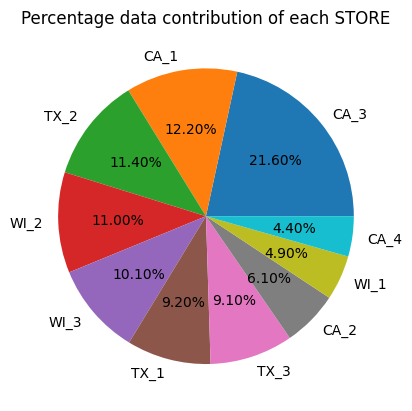

time: 13.4 s (started: 2024-05-05 11:04:01 +00:00)


In [114]:
plt.pie(
    df_sample['STORE'].value_counts(),
    labels=df_sample['STORE'].value_counts().index.tolist(),
    autopct='%.2f%%',
)
plt.title("Percentage data contribution of each STORE")
plt.show()

temp_plot = df_sample.copy()
temp_plot["MA_1MONTH_SELL"] = df_sample["SELL"].rolling(31).mean().fillna(0)
plot_timeseries_by_level(temp_plot, key_level = ["STORE"], target_var ="MA_1MONTH_SELL", agg_function = "mean")
plot_timeseries_by_level(temp_plot, key_level = ["STORE"], target_var ="MA_1MONTH_SELL", agg_function = "sum")

Following overview by each state I describe above, There are some closer point of view when looking data by store:
- Overall California still have the largest sales follow by Texas and Wisconsin
- Store "CA_4" start when have smallest sales and they up trend closely after 2014 catch other store. "WI_3" a little down trend but still have the largest store in Winsconsin
- Store in Texas not thing special, they up and down same trend and store "TX_1" still the smallest
- Store "CA_4" have a very weird sales, it peak at the first time in 2011 and Sep 2013 but have zero sales after that, especially in 2011
- On the other hand, store "CA_2" have the up trend with sales higher 2 store "CA_1", "CA_3" when it lower before

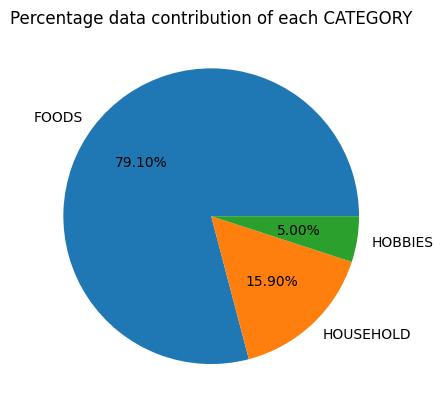

time: 4.67 s (started: 2024-05-05 08:38:24 +00:00)


In [ ]:
plt.pie(
    df_sample['CATEGORY'].value_counts(),
    labels=df_sample['CATEGORY'].value_counts().index.tolist(),
    autopct='%.2f%%',
)
plt.title("Percentage data contribution of each CATEGORY")
plt.show()

temp_plot = df_sample.copy()
temp_plot["MA_1WEEK_SELL"] = df_sample["SELL"].rolling(7).mean().fillna(0)
plot_timeseries_by_level(temp_plot, key_level = ["CATEGORY"], target_var ="MA_1WEEK_SELL", agg_function = "mean")

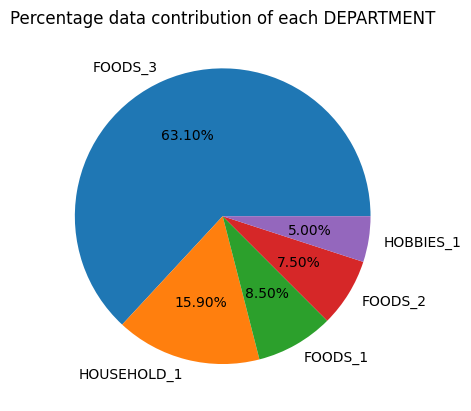

time: 4.3 s (started: 2024-05-05 08:38:29 +00:00)


In [ ]:
plt.pie(
    df_sample['DEPARTMENT'].value_counts(),
    labels=df_sample['DEPARTMENT'].value_counts().index.tolist(),
    autopct='%.2f%%',
)
plt.title("Percentage data contribution of each DEPARTMENT")
plt.show()

temp_plot = df_sample.copy()
temp_plot["MA_1WEEK_SELL"] = df_sample["SELL"].rolling(7).mean().fillna(0)
plot_timeseries_by_level(temp_plot, key_level = ["DEPARTMENT"], target_var ="MA_1WEEK_SELL", agg_function = "mean")

### Date time

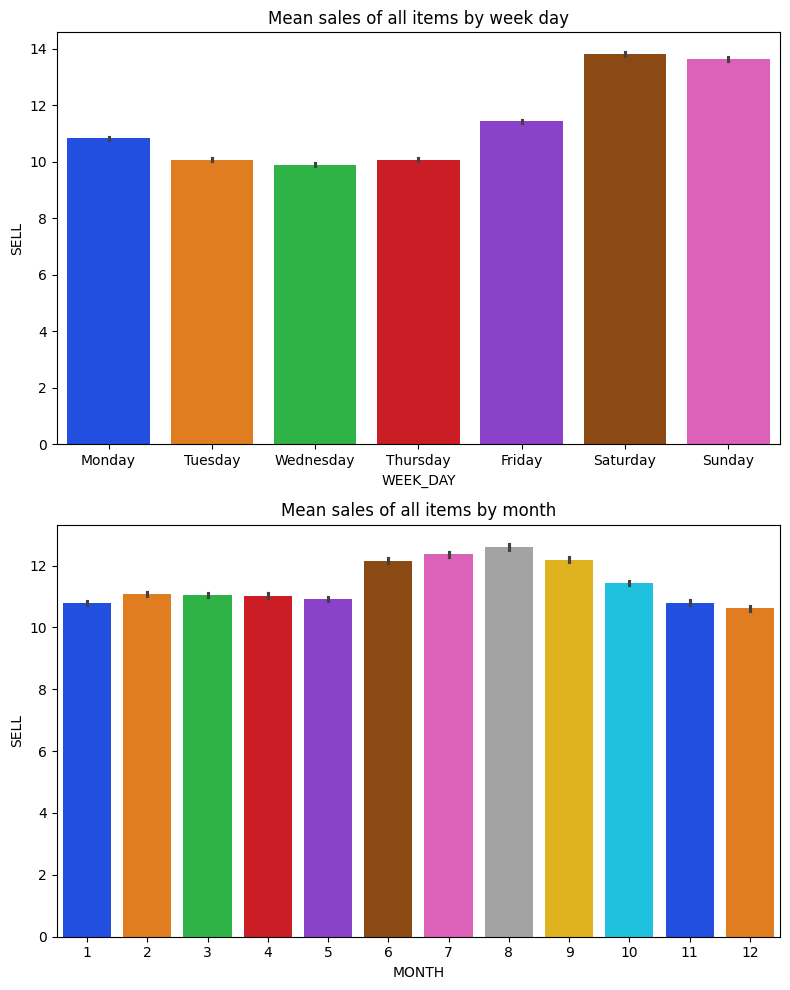

time: 1min 46s (started: 2024-05-05 08:41:47 +00:00)


In [ ]:
fig, ax = plt.subplots(2, figsize = (8, 10))

sns.barplot(
    data = df_sample,
    x = "WEEK_DAY",
    y = "SELL",
    palette = "bright",
    order = ['Monday',  'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
    ax = ax[0],
).set_title("Mean sales of all items by week day")

sns.barplot(
    data = df_sample,
    x = "MONTH",
    y = "SELL",
    palette = "bright",
    ax = ax[1],
).set_title("Mean sales of all items by month")
plt.tight_layout()
plt.show()

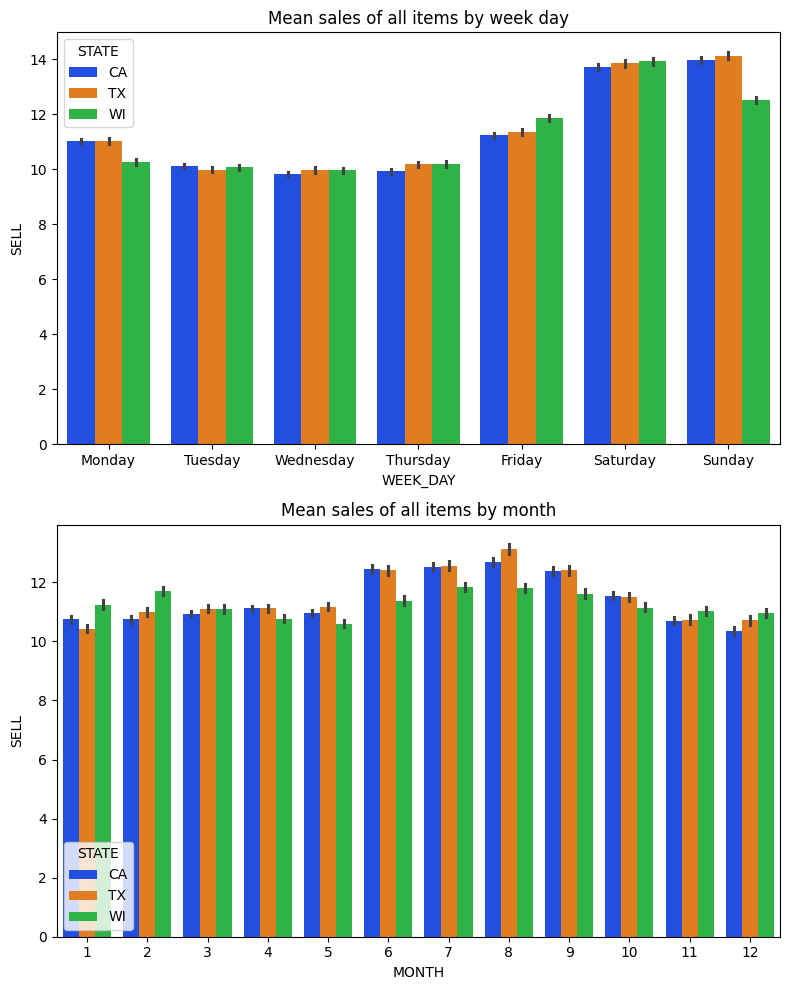

time: 1min 29s (started: 2024-05-05 08:43:33 +00:00)


In [ ]:
fig, ax = plt.subplots(2, figsize = (8, 10))

sns.barplot(
    data = df_sample,
    x = "WEEK_DAY",
    y = "SELL",
    palette = "bright",
    order = ['Monday',  'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
    ax = ax[0],
    hue = "STATE",
).set_title("Mean sales of all items by week day")

sns.barplot(
    data = df_sample,
    x = "MONTH",
    y = "SELL",
    palette = "bright",
    ax = ax[1],
    hue = "STATE"
).set_title("Mean sales of all items by month")
plt.tight_layout()
plt.show()

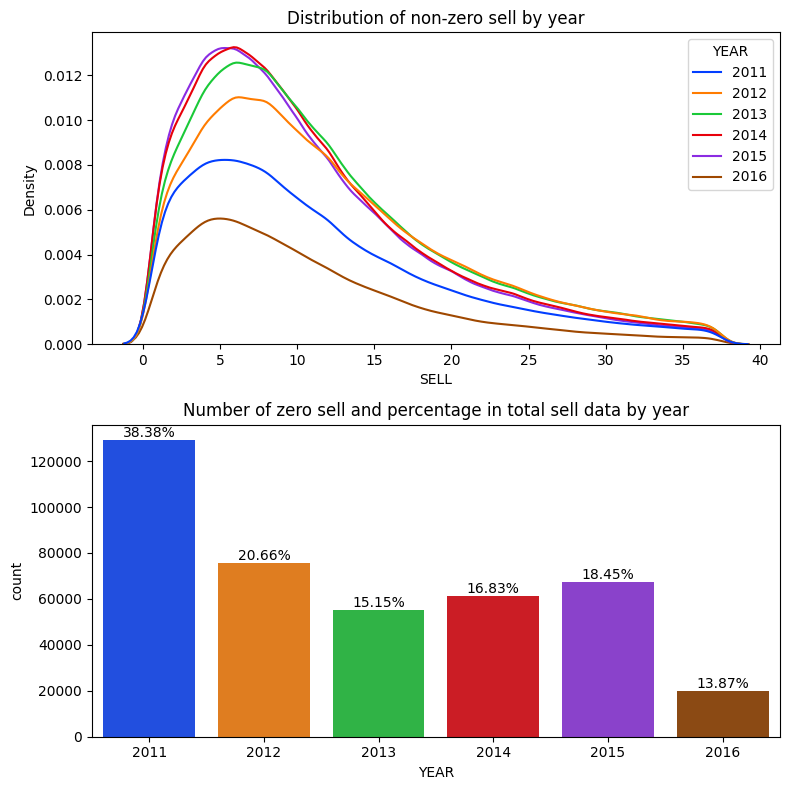

time: 14.4 s (started: 2024-05-05 08:45:02 +00:00)


In [ ]:
fig, ax = plt.subplots(2, figsize = (8, 8))

sns.kdeplot(
    df_sample[(df_sample["SELL"] > 0) & (df_sample["SELL"] <= df_sample["SELL"].quantile(0.95))],
    x = "SELL",
    ax = ax[0],
    hue = "YEAR",
    palette = "bright",
).set_title("Distribution of non-zero sell by year")

sns.countplot(
    df_sample[df_sample["SELL"] ==0],
    x = "YEAR",
    palette = "bright",
    ax =ax[1],
).set_title("Number of zero sell and percentage in total sell data by year")
percentages = df_sample[df_sample["SELL"] == 0]["YEAR"].value_counts() / df_sample["YEAR"].value_counts() *100

# ax[1].bar_label(ax[1].containers[0], labels=[f'{p:.2f}%' for p in percentages])
for i, p in enumerate(ax[1].patches):
    ax[1].annotate(f'{percentages[i+percentages.index.min()]:.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                   textcoords='offset points')
plt.tight_layout()
plt.show()

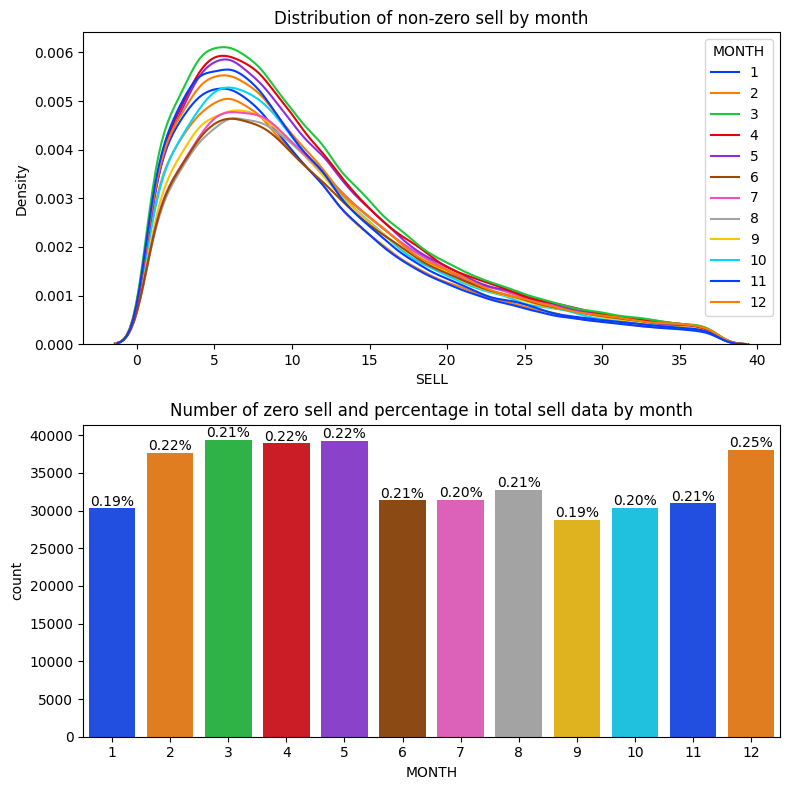

time: 13.6 s (started: 2024-05-05 08:45:17 +00:00)


In [ ]:
fig, ax = plt.subplots(2, figsize = (8, 8))

sns.kdeplot(
    df_sample[(df_sample["SELL"] > 0) & (df_sample["SELL"] <= df_sample["SELL"].quantile(0.95))],
    x = "SELL",
    ax = ax[0],
    hue = "MONTH",
    # bins = 15,
    multiple = "layer",
    palette = "bright"
).set_title("Distribution of non-zero sell by month")

sns.countplot(
    df_sample[df_sample["SELL"] ==0],
    x = "MONTH",
    palette = "bright",
    ax =ax[1]
).set_title("Number of zero sell and percentage in total sell data by month")
percentages = df_sample[df_sample["SELL"] == 0]["MONTH"].value_counts() / df_sample["MONTH"].value_counts()

# ax[1].bar_label(ax[1].containers[0], labels=[f'{p*100:.2f}%' for p in percentages])
for i, p in enumerate(ax[1].patches):
    ax[1].annotate(f'{percentages[i+percentages.index.min()]:.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                   textcoords='offset points')
plt.tight_layout()
plt.show()

Wrap up:

- The weekly pattern is strong, with Sat and Sun have high sales. Also Monday seems to benefit a bit from the weekend effect.

- The months of autumn like July have a highest sales for 3 different states similarly

- The zero sales seriously impact to the margin sales, the autumn have a small percentages zero sales can interpret why they have a highest sales. On the other hand, Dec have 0.25% zero sales but the margin not smaller than Jan or Feb cause the small number of order but have a quite large volume

- 2011 have 38% zeros sales as a highest sales compare to other years, maybe this present some new product have launch lately or not adopted on market

### sell price

Text(0.5, 1.0, 'Boxplot sell price of category in each state')

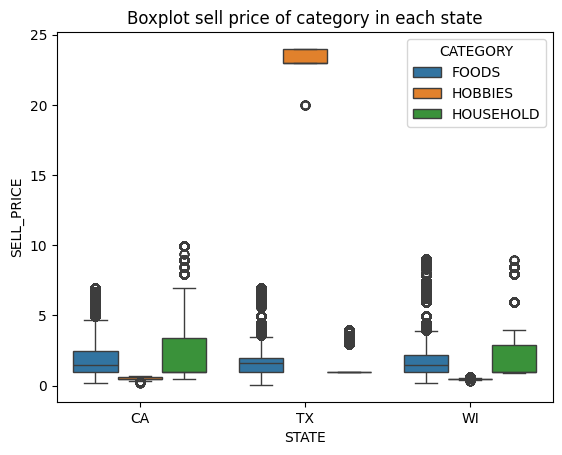

time: 11.7 s (started: 2024-05-05 08:48:30 +00:00)


In [ ]:
sns.boxplot(
    data = df_sample,
    x = "STATE",
    y = "SELL_PRICE",
    hue = "CATEGORY",
).set_title("Boxplot sell price of category in each state")

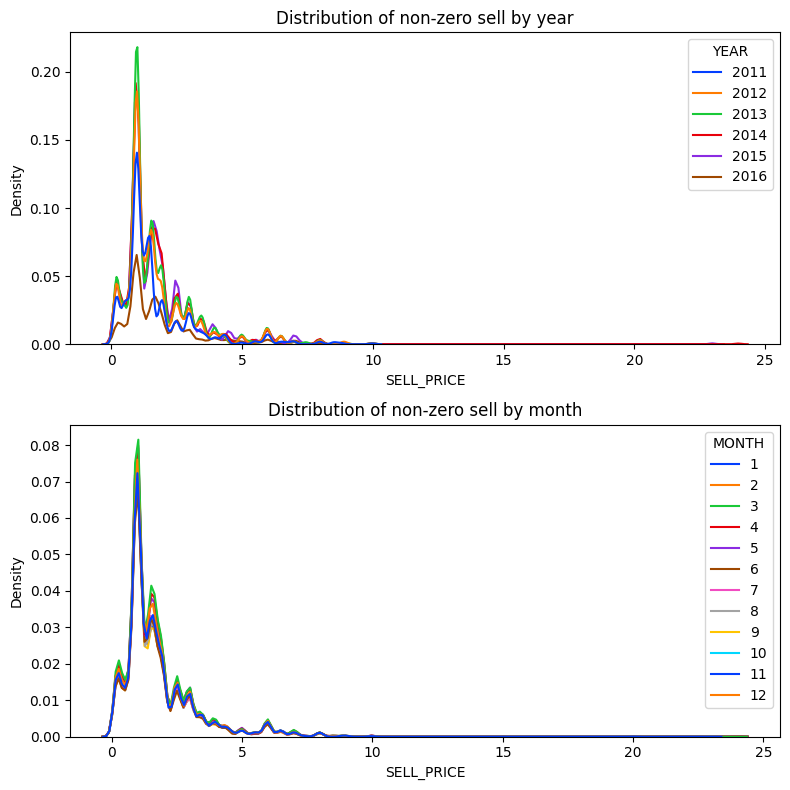

time: 32 s (started: 2024-05-05 08:48:42 +00:00)


In [ ]:
fig, ax = plt.subplots(2, figsize = (8, 8))

sns.kdeplot(
    df_sample,
    x = "SELL_PRICE",
    hue = "YEAR",
    ax = ax[0],
    # bins = 15,
    palette = "bright"
).set_title("Distribution of non-zero sell by year")

sns.kdeplot(
    df_sample,
    x = "SELL_PRICE",
    hue = "MONTH",
    ax = ax[1],
    # bins = 15,
    palette = "bright"
).set_title("Distribution of non-zero sell by month")

plt.tight_layout()
plt.show()

- Overall first 3 years have a smaller price than latest 3 years, this might be come up by inflation or new product have released and contributed with higher average price

- The price distribution by month have nothing different, price of product have a small changes over years

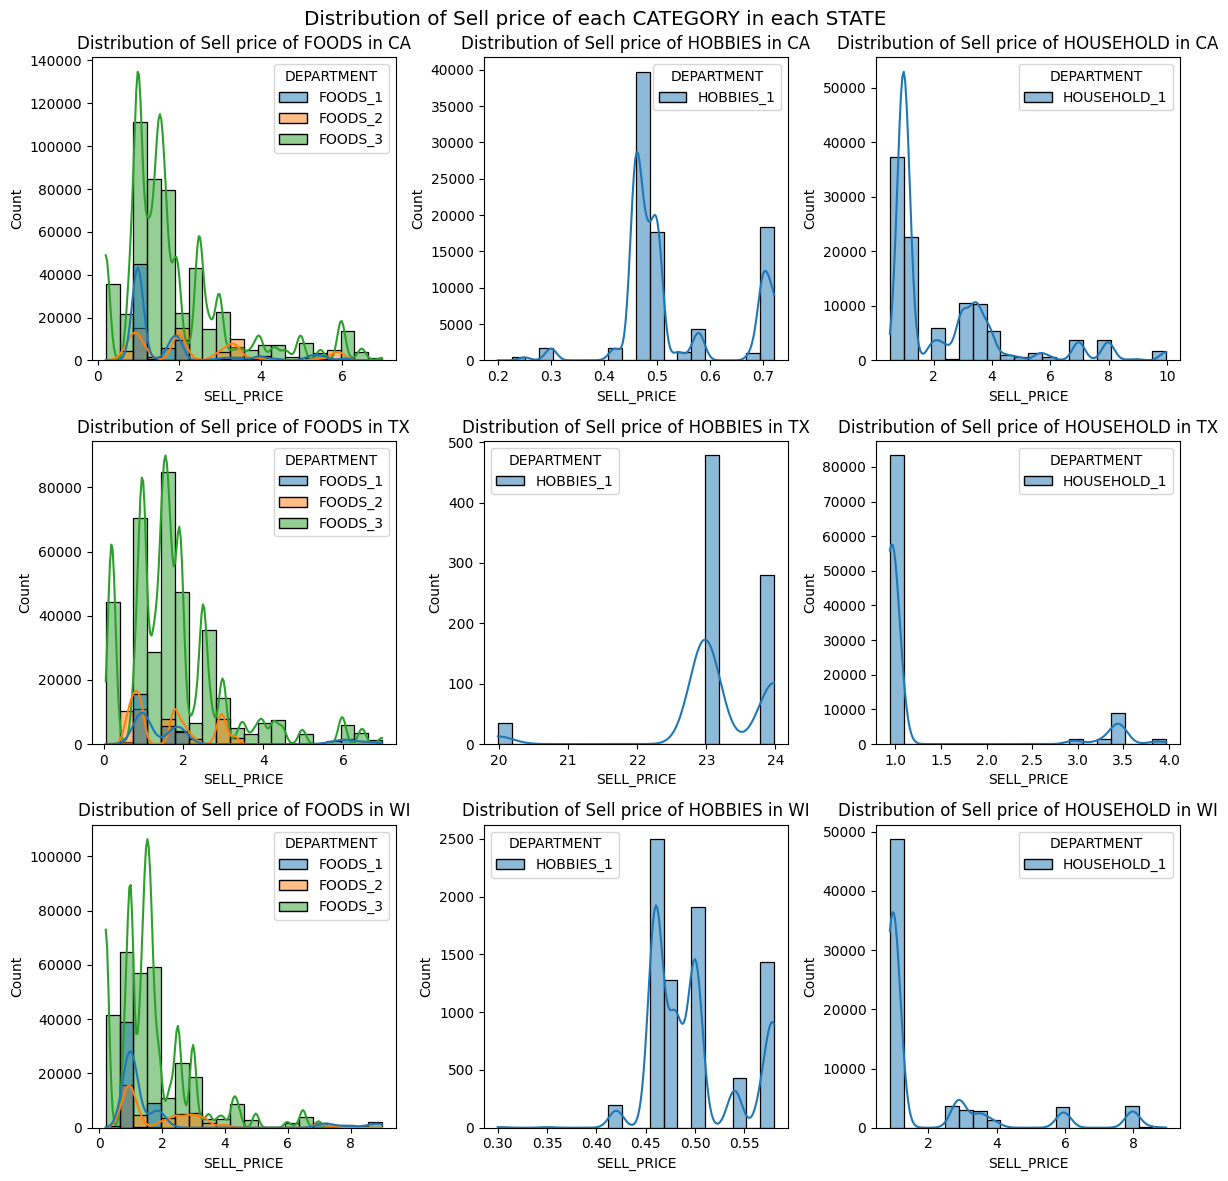

time: 29.5 s (started: 2024-05-05 08:49:14 +00:00)


In [ ]:
fig, ax = plt.subplots(3, 3, figsize = (12, 12))

for (i, state) in enumerate(df_sample["STATE"].unique()):
    for (j, cate) in enumerate(df_sample["CATEGORY"].unique()):
        df_group = df_sample[
            (df_sample["STATE"] == state)
            & (df_sample["CATEGORY"] == cate)
        ]
        try:
            sns.histplot(
                data = df_group,
                x = "SELL_PRICE",
                hue = "DEPARTMENT",
                ax = ax[i, j],
                kde = True,
                bins = 20,
            ).set_title(f"Distribution of Sell price of {cate} in {state}")
        except:
            pass

fig.suptitle("Distribution of Sell price of each CATEGORY in each STATE", fontsize="x-large")
plt.tight_layout()
plt.show()

- Overall, the distributions are almost identical between the 3 states. There are some minute differences in the FOODS category, but this might be due the smoothing bandwidth size. For all practical purposes, I think that we can treat the price distributions as equal.

- Among the three food categories department 3 (i.e. “FOODS_3”) does not contain a high-price tail.

- The HOBBIES category is the most diverse range in different state

- The HOUSEHOLD price distributions are quite similar FOOD in state CA

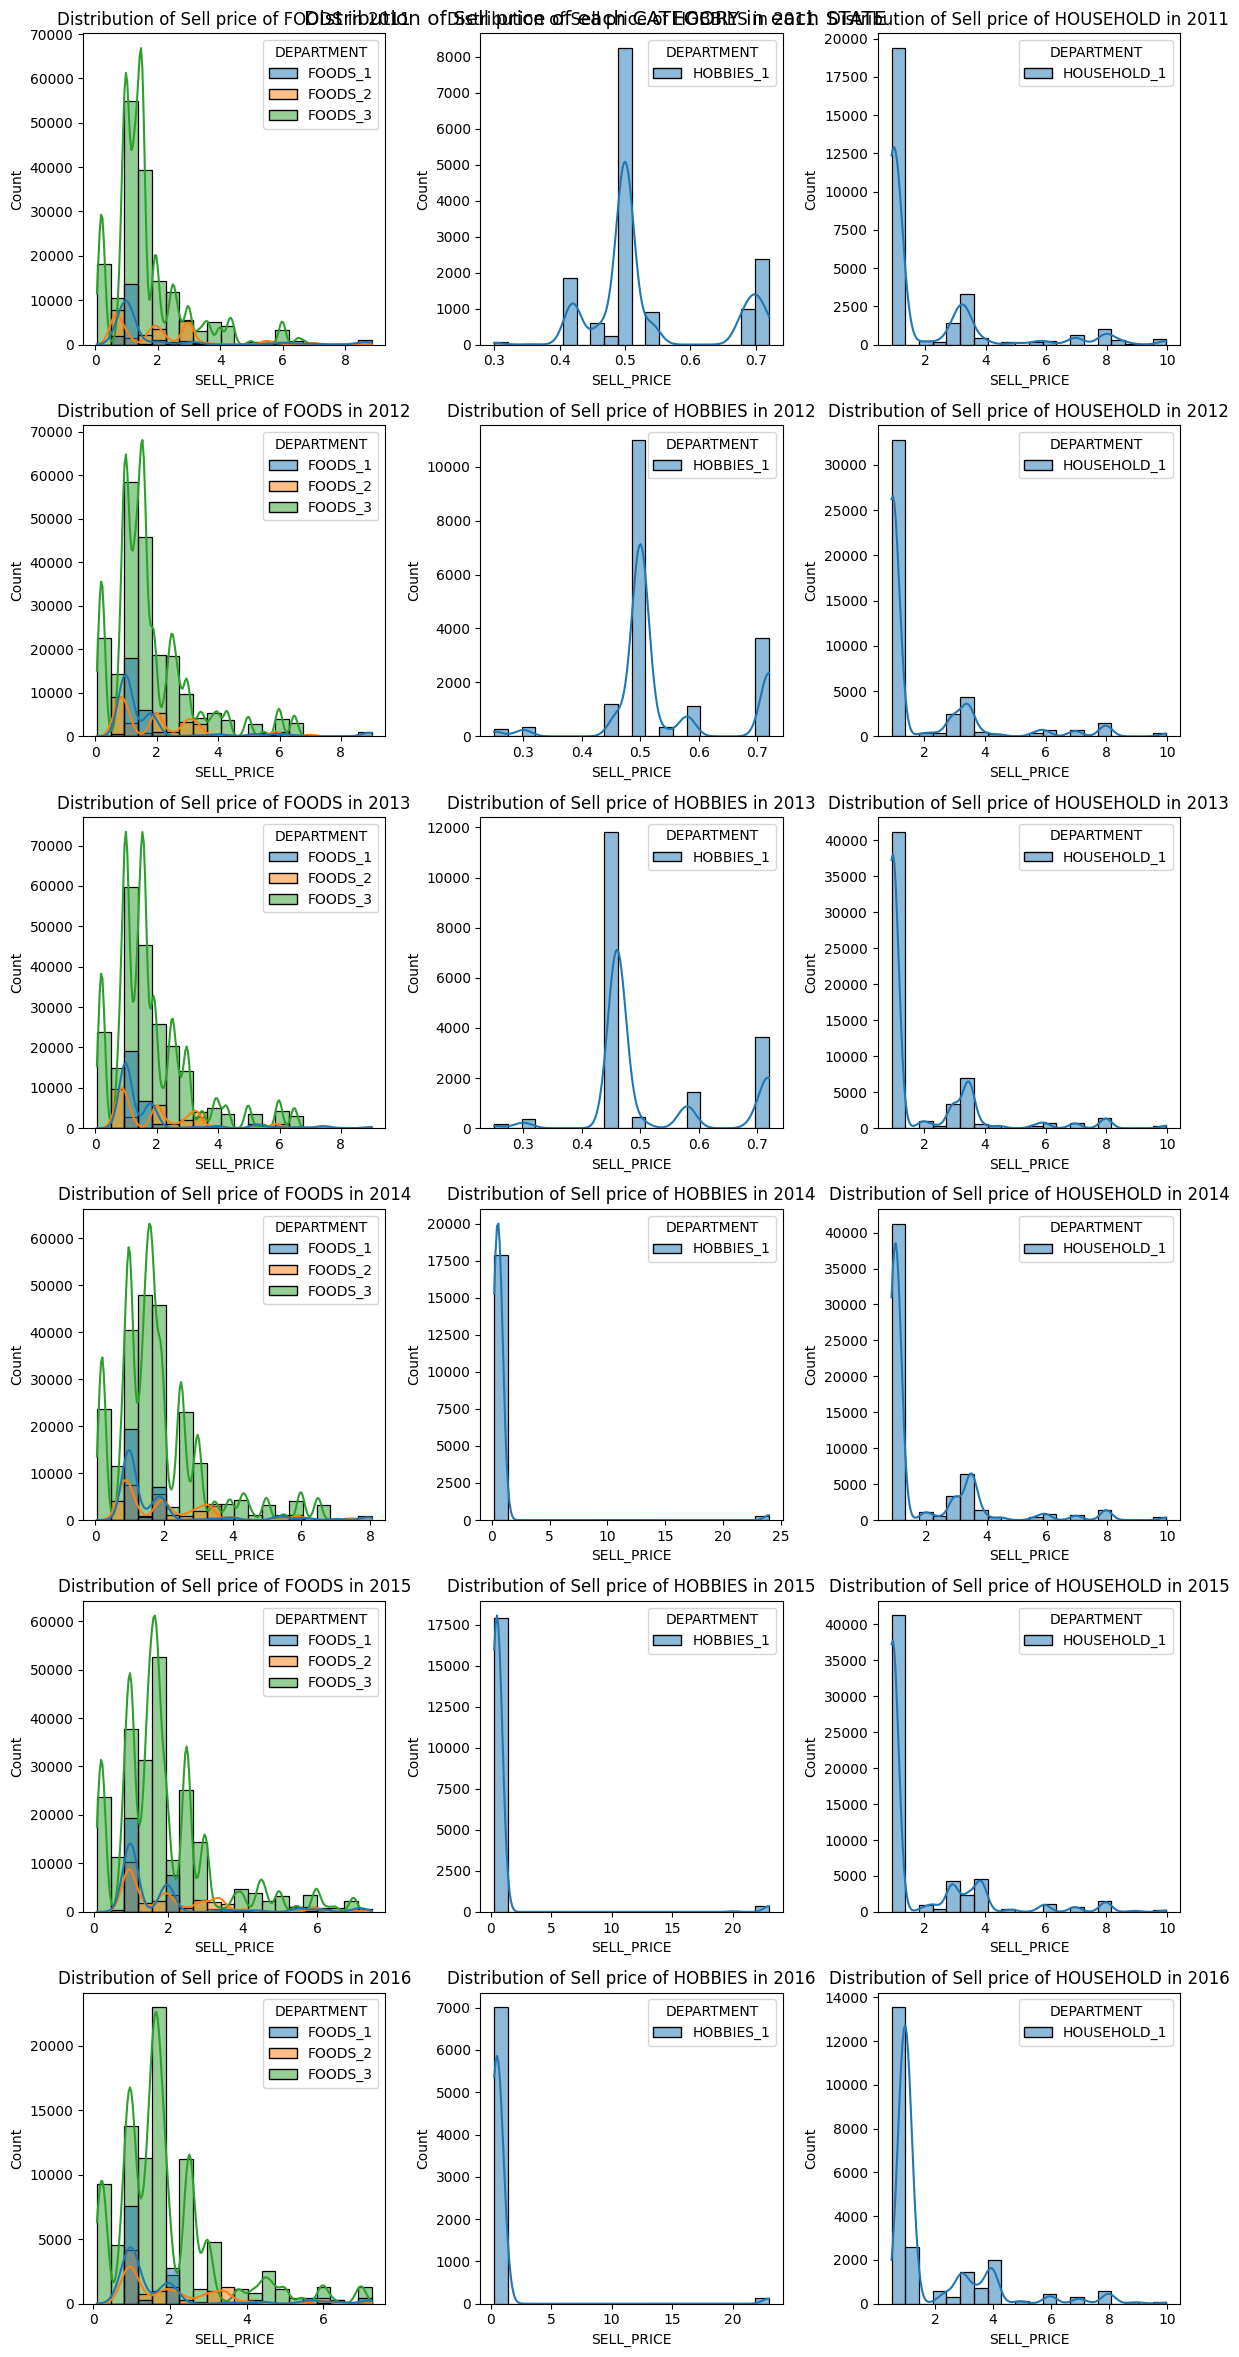

time: 41 s (started: 2024-05-05 08:49:43 +00:00)


In [ ]:
fig, ax = plt.subplots(6, 3, figsize = (12, 24))

for (i, year) in enumerate(df_sample["YEAR"].unique()):
    for (j, cate) in enumerate(df_sample["CATEGORY"].unique()):
        df_group = df_sample[
            (df_sample["YEAR"] == year)
            & (df_sample["CATEGORY"] == cate)
        ]
        try:
            sns.histplot(
                data = df_group,
                x = "SELL_PRICE",
                hue = "DEPARTMENT",
                ax = ax[i, j],
                kde = True,
                bins = 20,
            ).set_title(f"Distribution of Sell price of {cate} in {year}")
        except:
            pass

fig.suptitle("Distribution of Sell price of each CATEGORY in each STATE", fontsize="x-large")
plt.tight_layout()
plt.show()

- Overall, the price distributions are pretty stable over the years, with only slight increases that are likely due to inflation.

- The HOUSEHOLD departments are stable. FOODS shows small changes like the relative growth of the $1 peak of FOODS_1.

- An interesting evolution is HOBBIES_2, which over time becomes much more bimodal: the second peak at $1 is increasing in importance until it almost reaches the level of the main peak just above 2 dollars. At the same time the small secondary peak at half a dollar in HOBBIES_1 becomes more flat after 2012.

Lets check that price can impact sales product result to change pattern of margin

In [ ]:
temp_plot = df_sample.copy()
temp_plot["GSV"] = temp_plot["SELL"] * temp_plot["SELL_PRICE"]
temp_plot["MA_1WEEK_SELL"] = temp_plot["GSV"].rolling(7).mean().fillna(0)

plot_timeseries_by_level(temp_plot, key_level = ["STATE"], target_var ="MA_1WEEK_SELL", agg_function = "mean")
plot_timeseries_by_level(temp_plot, key_level = ["STORE"], target_var ="MA_1WEEK_SELL", agg_function = "mean")
plot_timeseries_by_level(temp_plot, key_level = ["CATEGORY"], target_var ="MA_1WEEK_SELL", agg_function = "mean")
plot_timeseries_by_level(temp_plot, key_level = ["DEPARTMENT"], target_var ="MA_1WEEK_SELL", agg_function = "mean")

time: 25.2 s (started: 2024-05-05 09:16:15 +00:00)


- Seem to be margin have the similar pattern as sell order. In other words, price have a positive correlation with sell and this helpful for engineer features to represent pattern of sales

### SNAP

In [ ]:
temp_plot = df_sample.copy()

for col in ['EVENT_NAME_1', 'EVENT_TYPE_1', 'EVENT_NAME_2', 'EVENT_TYPE_2']:
    new_col = "IS_" + col
    temp_plot[new_col] = np.where((temp_plot[col].isnull() == True) | (temp_plot[col] == 0), "FALSE","TRUE")

time: 4.39 s (started: 2024-05-05 08:50:24 +00:00)


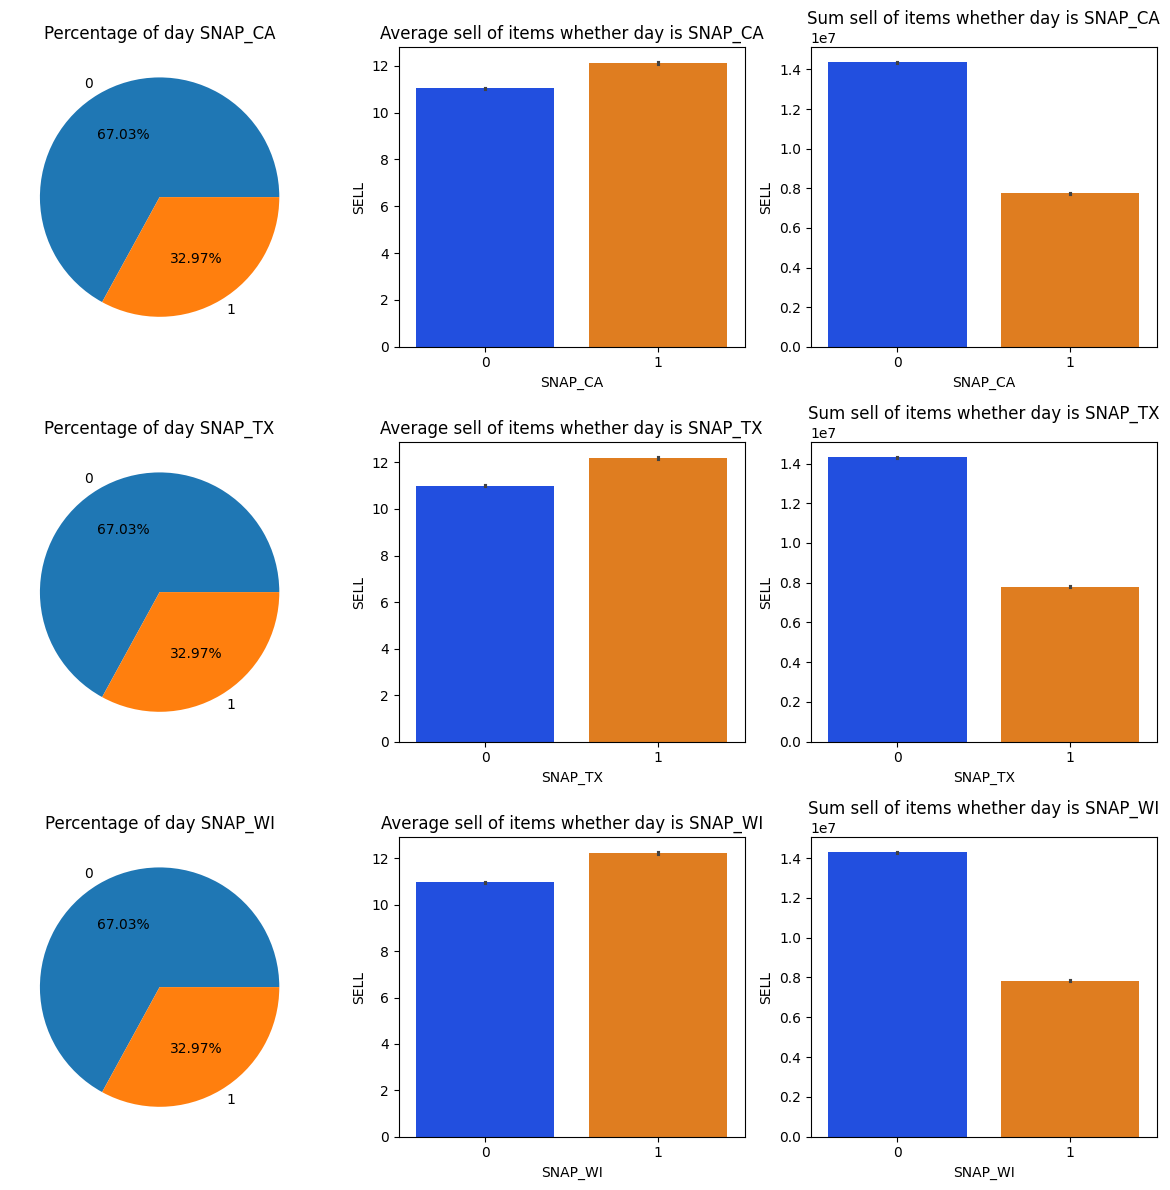

time: 7min 44s (started: 2024-05-05 08:50:29 +00:00)


In [ ]:
fig, ax = plt.subplots(3, 3, figsize = (12, 12))

for (i, col) in enumerate(["SNAP_CA","SNAP_TX","SNAP_WI"]):
    ax[i, 0].pie(
        temp_plot[col].value_counts(),
        labels = temp_plot[col].value_counts().index.tolist(),
        autopct='%.2f%%',
    )
    ax[i, 0].set_title("Percentage of day " + col)

    sns.barplot(
        temp_plot,
        x = col,
        y = "SELL",
        estimator = "mean",
        ax = ax[i, 1],
        palette = "bright"
    )
    ax[i, 1].set_title("Average sell of items whether day is " + col)

    sns.barplot(
        temp_plot,
        x = col,
        y = "SELL",
        estimator = "sum",
        ax = ax[i, 2],
        palette = "bright"
    )
    ax[i, 2].set_title("Sum sell of items whether day is " + col)

plt.tight_layout()
plt.show()

First, we need to understand what is SNAP and how does it impact to sell in FCMG

- The Supplemental Nutrition Assistance Program (SNAP) provides food benefits to low-income families, allowing them to supplement their grocery budget. These benefits enable recipients to afford nutritious food, which is essential for health and overall well-being.

- In the United States, SNAP follows a monthly issuance schedule for distributing benefits. While the exact day of distribution may vary by state, recipients typically receive their benefits on the same calendar day each month. This ensures that they receive benefits approximately every 30 to 31 days, depending on the month.

Overall, average sell by order of event a little higher than non-event day. But the contribution total sell of non-event day have dominate event day as the frequency of its

In [ ]:
temp_plot["WEEK_OF_MONTH"] = temp_plot["DATE"].apply(week_of_month)

time: 14.4 s (started: 2024-05-05 08:58:13 +00:00)


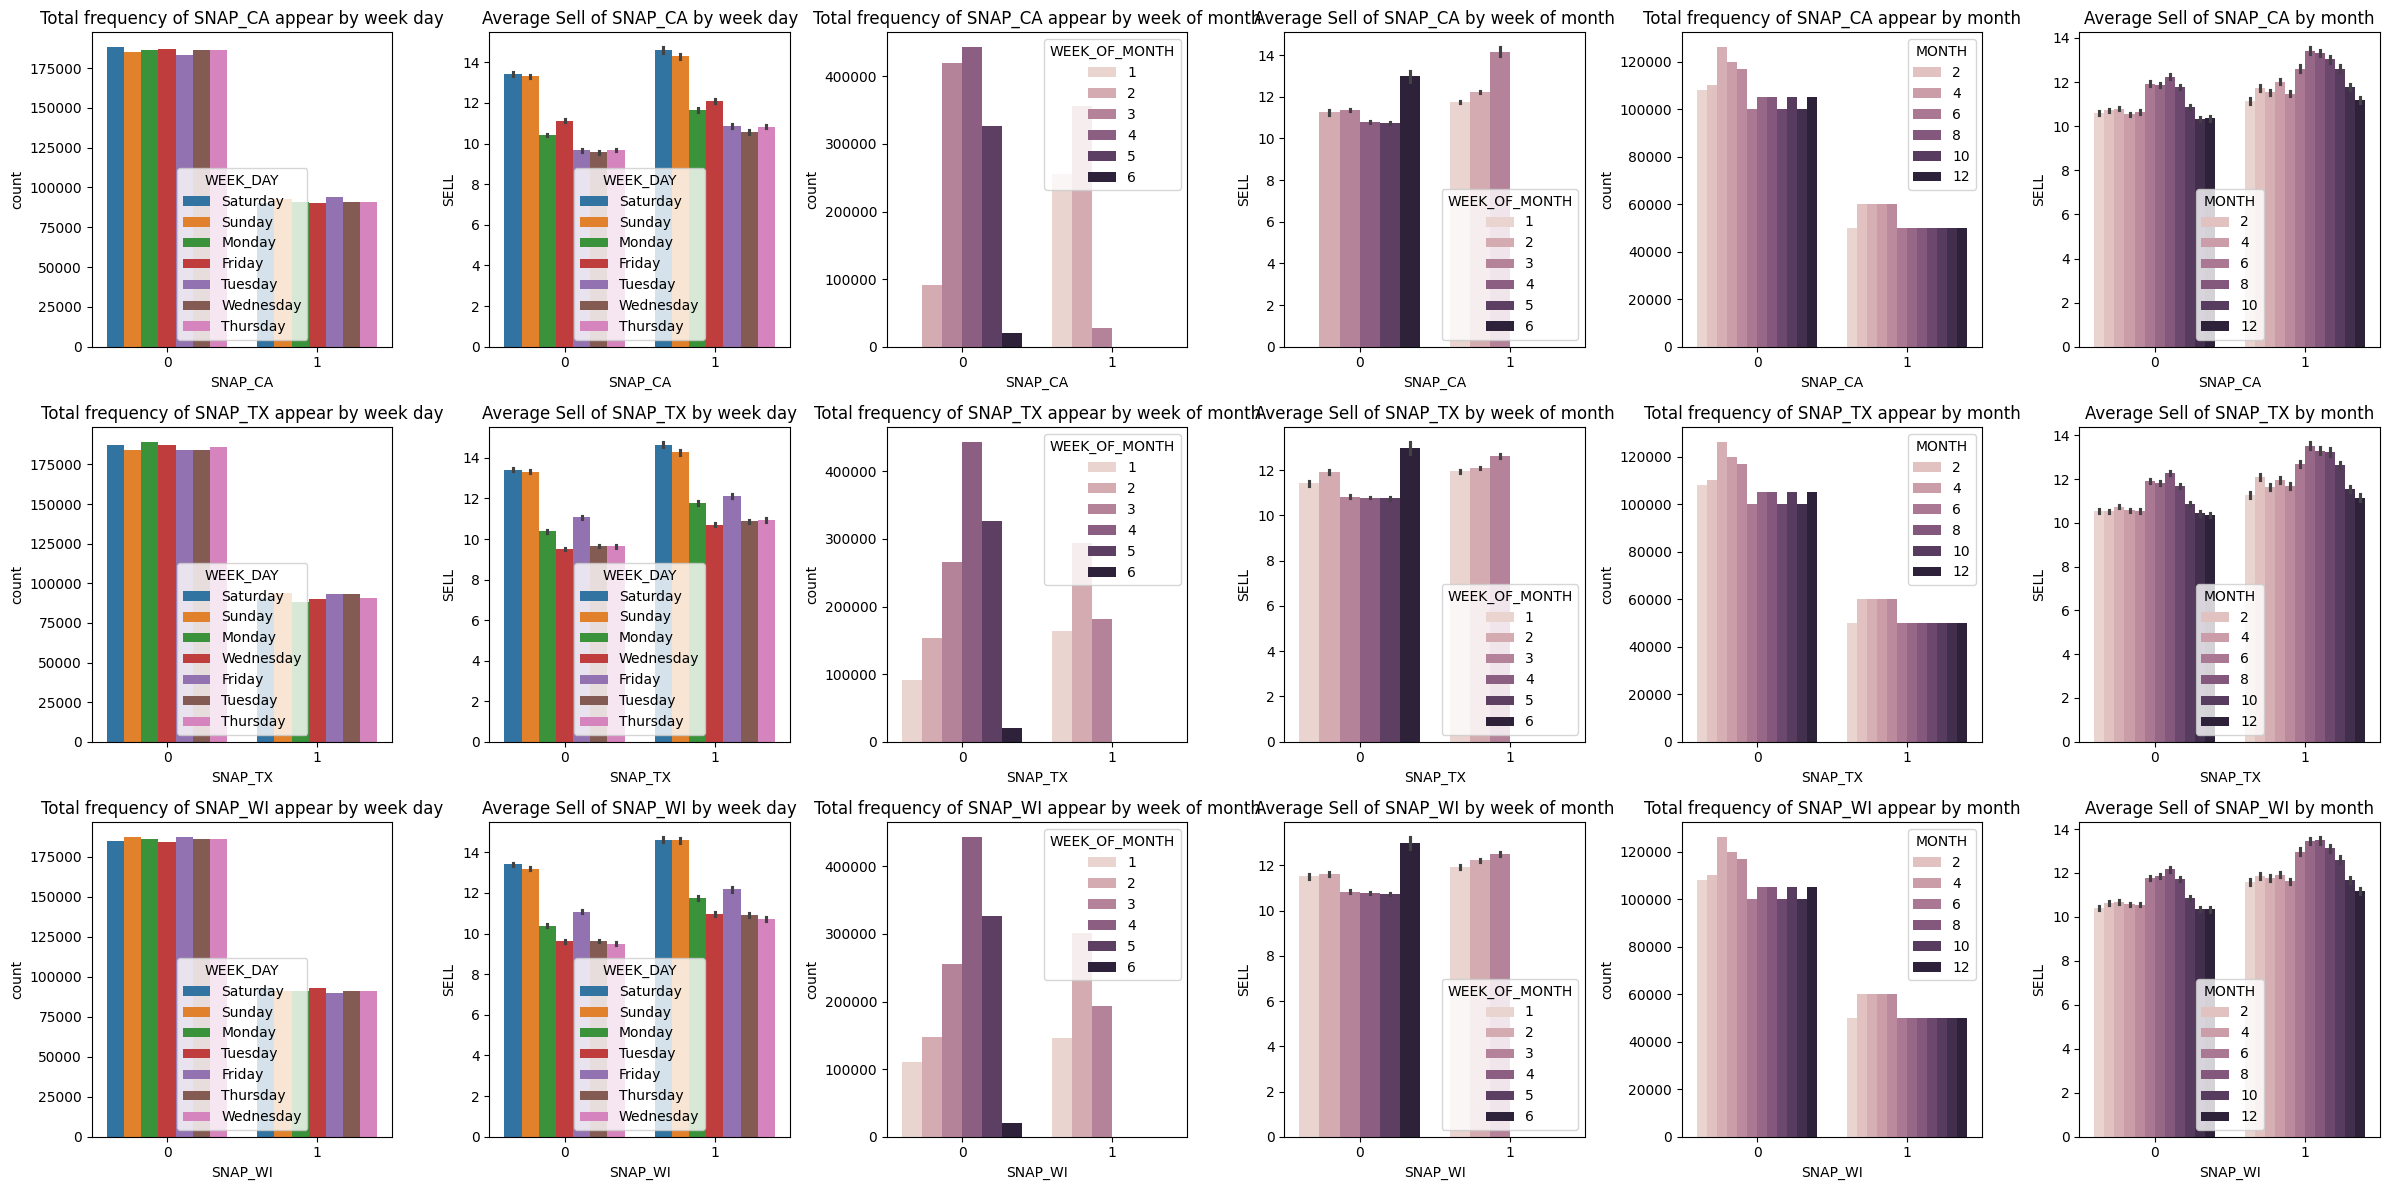

time: 8min 31s (started: 2024-05-05 08:58:28 +00:00)


In [ ]:
fig, ax = plt.subplots(3, 6, figsize = (24, 12))

for (i, col) in enumerate(["SNAP_CA","SNAP_TX","SNAP_WI"]):
    sns.countplot(
        temp_plot,
        x = col,
        hue = "WEEK_DAY",
        ax = ax[i, 0],
    ).set_title(f"Total frequency of {col} appear by week day")

    sns.barplot(
        temp_plot,
        x = col,
        y = "SELL",
        hue = "WEEK_DAY",
        estimator = "mean",
        # palette = "bright",
        ax = ax[i, 1],
    ).set_title(f"Average Sell of {col} by week day")

    sns.countplot(
        temp_plot,
        x = col,
        hue = "WEEK_OF_MONTH",
        ax = ax[i, 2],
    ).set_title(f"Total frequency of {col} appear by week of month")

    sns.barplot(
        temp_plot,
        x = col,
        y = "SELL",
        hue = "WEEK_OF_MONTH",
        estimator = "mean",
        # palette = "bright",
        ax = ax[i, 3],
    ).set_title(f"Average Sell of {col} by week of month")

    sns.countplot(
        temp_plot,
        x = col,
        hue = "MONTH",
        ax = ax[i, 4],
    ).set_title(f"Total frequency of {col} appear by month")

    sns.barplot(
        temp_plot,
        x = col,
        y = "SELL",
        hue = "MONTH",
        estimator = "mean",
        # palette = "bright",
        ax = ax[i, 5],
    ).set_title(f"Average Sell of {col} by month")

plt.tight_layout()
plt.show()

- The pattern of SNAP by week day similar as pattern of week day vs sell, average sales of Sat and Sun higher others and non-event day

- The interesting point that SNAP days happen in the first half of each month, no later than the 15th, this might be aligned in this 3 state particularly. This certainly helps to measure their impact and make predictions more robust. The week 3 of SNAP still have the most contribution


In [ ]:
temp_plot["MA_1MONTH_SELL"] = df_sample["SELL"].rolling(31).mean().fillna(0)
plot_timeseries_by_level(temp_plot, key_level = ["SNAP_CA","SNAP_TX","SNAP_WI"], target_var ="MA_1MONTH_SELL", agg_function = "mean")

time: 9.56 s (started: 2024-05-05 09:07:00 +00:00)


To avoid confusing, I only consider time series where in one of 3 unique SNAP only, I dont consider mix SNAP

- Totally, average sell in a month of event SNAP more stable than sell non-event SNAP

- SNAP_CA have bigger sell than other 2 SNAP, Its fluctuated in some period from March to May and have some down trend lower other 2 SNAP

- The SNAP days have clearly higher sales in every state. The largest difference to non-SNAP days is present for WI; this is abundantly clear from both the time series plots and the daily sales percentages. CA sales are closest for the two groups, but SNAP days are still almost 2 percentage points above 50%.

### Event

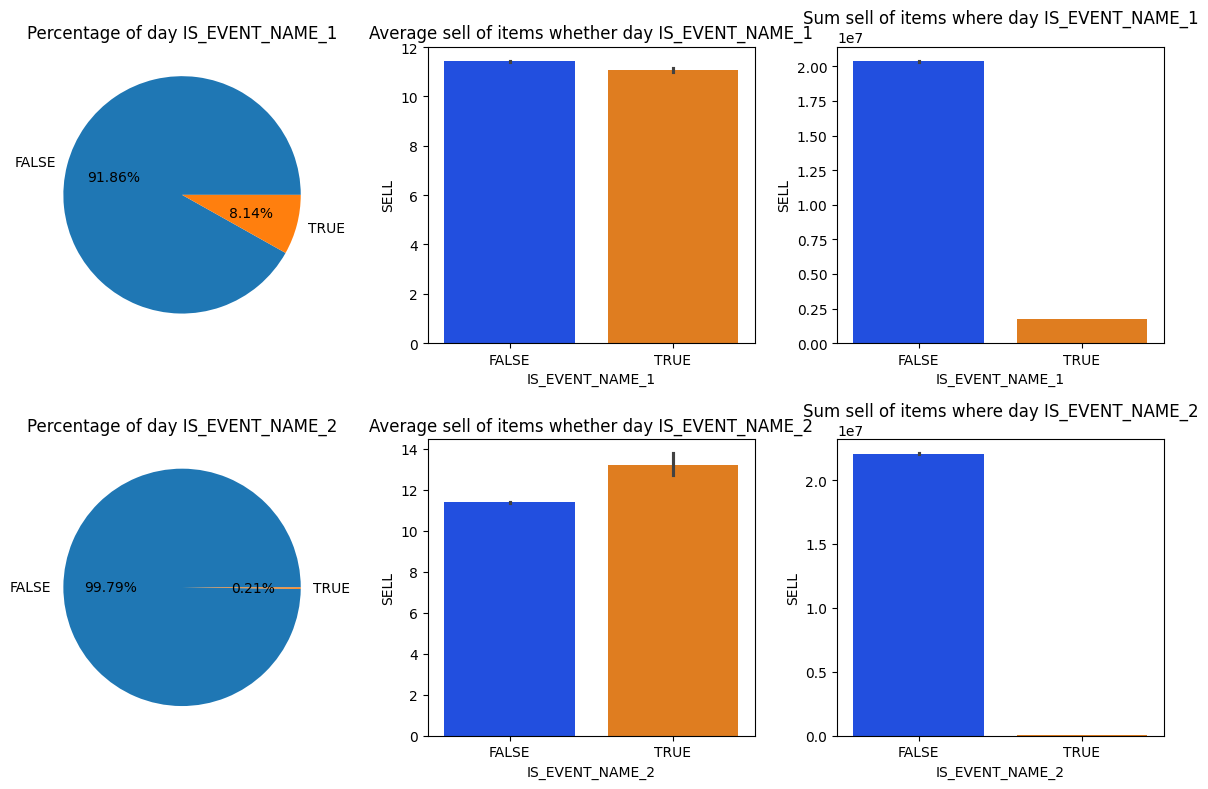

time: 6min 41s (started: 2024-05-05 09:07:09 +00:00)


In [ ]:
fig, ax = plt.subplots(2, 3, figsize = (12, 8))

for (i, col) in enumerate(["IS_EVENT_NAME_1","IS_EVENT_NAME_2"]):
    ax[i, 0].pie(
        temp_plot[col].value_counts(),
        labels = temp_plot[col].value_counts().index.tolist(),
        autopct='%.2f%%',
    )
    ax[i, 0].set_title("Percentage of day " + col)
    sns.barplot(
        temp_plot,
        x = col,
        y = "SELL",
        palette = "bright",
        estimator = "mean",
        ax = ax[i, 1]
    )
    ax[i, 1].set_title("Average sell of items whether day " + col)

    sns.barplot(
        temp_plot,
        x = col,
        y = "SELL",
        palette = "bright",
        estimator = "sum",
        ax = ax[i, 2]
    )
    ax[i, 2].set_title("Sum sell of items where day " + col)

plt.tight_layout()
plt.show()

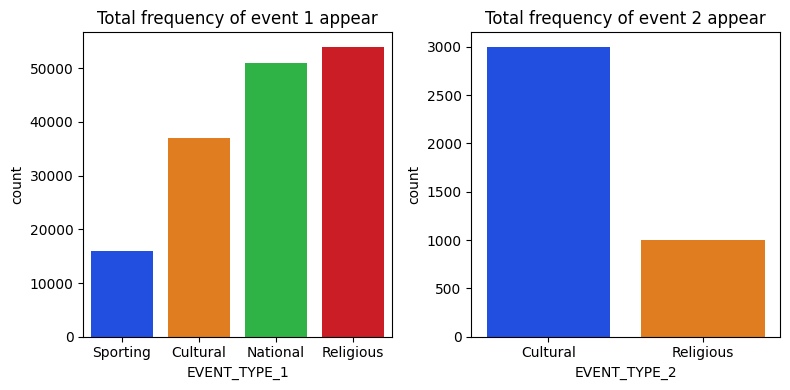

time: 11.5 s (started: 2024-05-05 09:13:51 +00:00)


In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (8,4))
sns.countplot(
    data = temp_plot,
    x = "EVENT_TYPE_1",
    palette = "bright",
    ax = ax[0]
).set_title("Total frequency of event 1 appear")

sns.countplot(
    data = temp_plot,
    x = "EVENT_TYPE_2",
    palette = "bright",
    ax = ax[1]
).set_title("Total frequency of event 2 appear")
plt.tight_layout()
plt.show()

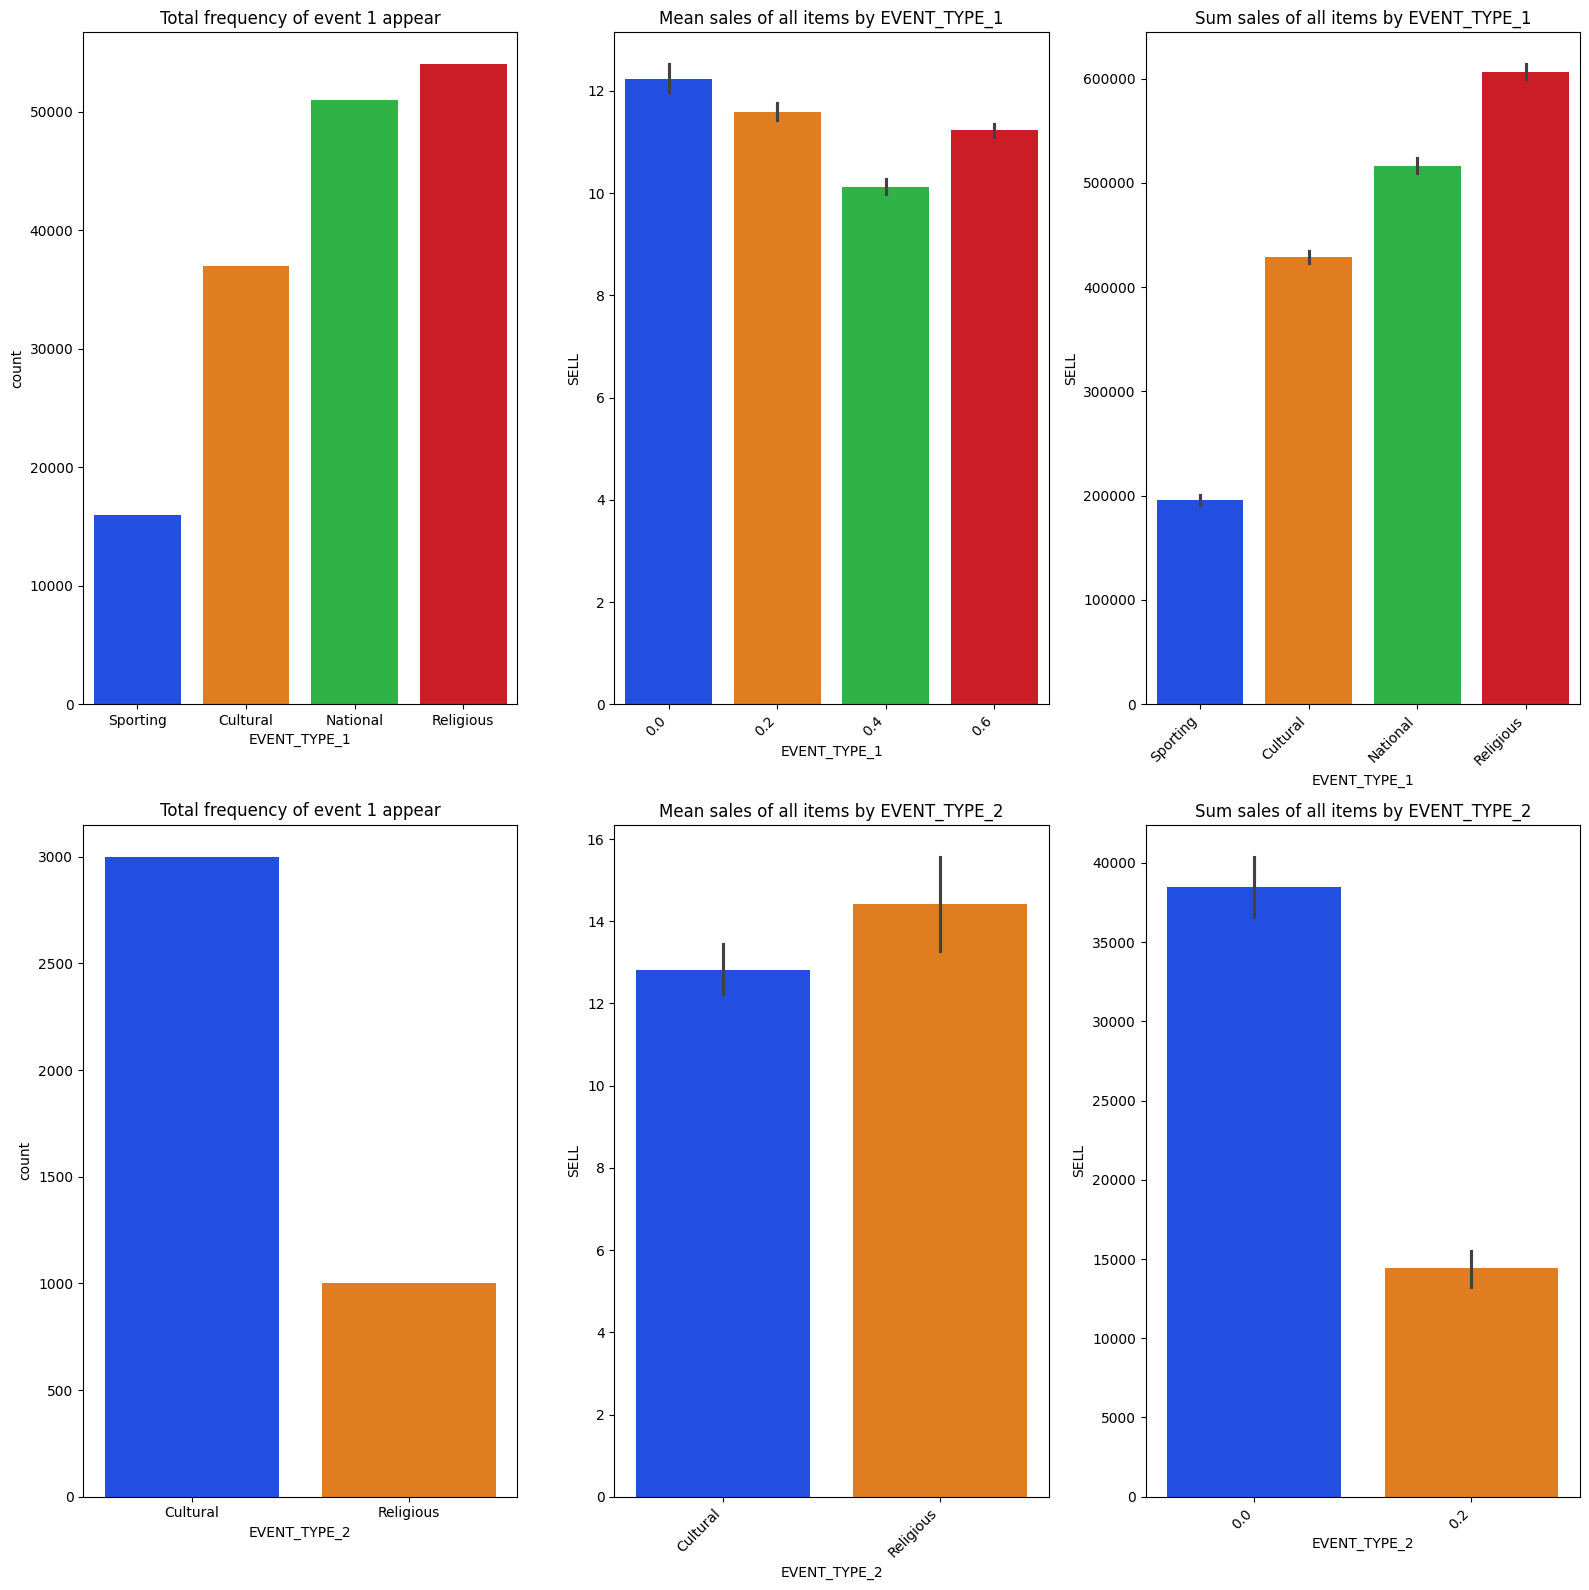

time: 46.9 s (started: 2024-05-05 09:49:02 +00:00)


In [ ]:
fig, ax = plt.subplots(2, 3, figsize = (16, 16))

for i in enumerate(["EVENT_TYPE_1","EVENT_TYPE_2"]):
    sns.countplot(
        data = df_sample,
        x = i[1],
        palette = "bright",
        ax = ax[i[0], 0]
    ).set_title("Total frequency of event 1 appear")

    sns.barplot(
        data = df_sample,
        x = i[1],
        y = "SELL",
        palette = "bright",
        ax = ax[i[0], 1],
    )
    ax[i[0], 1].set_xticklabels(ax[1, i[0]].get_xticklabels(), rotation=45, ha="right")
    ax[i[0], 1].set_title("Mean sales of all items by "+str(i[1]))

    sns.barplot(
        data = df_sample,
        x = i[1],
        y = "SELL",
        palette = "bright",
        ax = ax[i[0], 2],
        estimator = "sum"
    )
    ax[i[0], 2].set_xticklabels(ax[0, i[0]].get_xticklabels(), rotation=45, ha="right")
    ax[i[0], 2].set_title("Sum sales of all items by "+str(i[1]))

plt.tight_layout()
plt.show()

Overall, pattern of event and non-event similar as SNAP when total sales contribution of event vs non-event equal to percentages and avg sales of event a little bit higher than non-event

## Correlation

<Axes: >

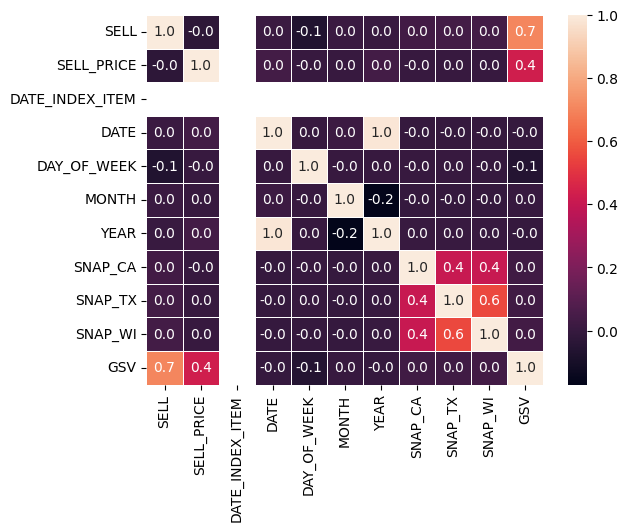

time: 3.42 s (started: 2024-05-05 10:07:14 +00:00)


In [ ]:
df_sample["GSV"] = df_sample["SELL"] * df_sample["SELL_PRICE"]
sns.heatmap(df_sample[[x for x in df_sample.columns if df_sample[x].dtype != "O"]].corr(), annot = True, linewidth=.5, fmt=".1f")

In [ ]:
from matplotlib.patches import Polygon

def calmap(ax, year, data):
    ax.tick_params('x', length=0, labelsize="medium", which='major')
    ax.tick_params('y', length=0, labelsize="x-small", which='major')

    # Month borders
    xticks, labels = [], []
    start = datetime(year,1,1).weekday()
    for month in range(1,13):
        first = datetime(year, month, 1)
        last = first + relativedelta(months=1, days=-1)

        y0 = first.weekday()
        y1 = last.weekday()
        x0 = (int(first.strftime("%j"))+start-1)//7
        x1 = (int(last.strftime("%j"))+start-1)//7

        P = [ (x0,   y0), (x0,    7),  (x1,   7),
              (x1,   y1+1), (x1+1,  y1+1), (x1+1, 0),
              (x0+1,  0), (x0+1,  y0) ]
        xticks.append(x0 +(x1-x0+1)/2)
        labels.append(first.strftime("%b"))
        poly = Polygon(P, edgecolor="black", facecolor="None",
                       linewidth=1, zorder=20, clip_on=False)
        ax.add_artist(poly)

    ax.set_xticks(xticks)
    ax.set_xticklabels(labels)
    ax.set_yticks(0.5 + np.arange(7))
    ax.set_yticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
    ax.set_title("{}".format(year), weight="semibold")

    # Clearing first and last day from the data
    valid = datetime(year, 1, 1).weekday()
    data[:valid,0] = np.nan
    valid = datetime(year, 12, 31).weekday()
    # data[:,x1+1:] = np.nan
    data[valid+1:,x1] = np.nan

    # Showing data
    ax.imshow(data, extent=[0,53,0,7], zorder=10, vmin=-1, vmax=1,
              cmap="RdYlBu_r", origin="lower", alpha=.75)

time: 6.74 ms (started: 2024-05-05 10:08:02 +00:00)


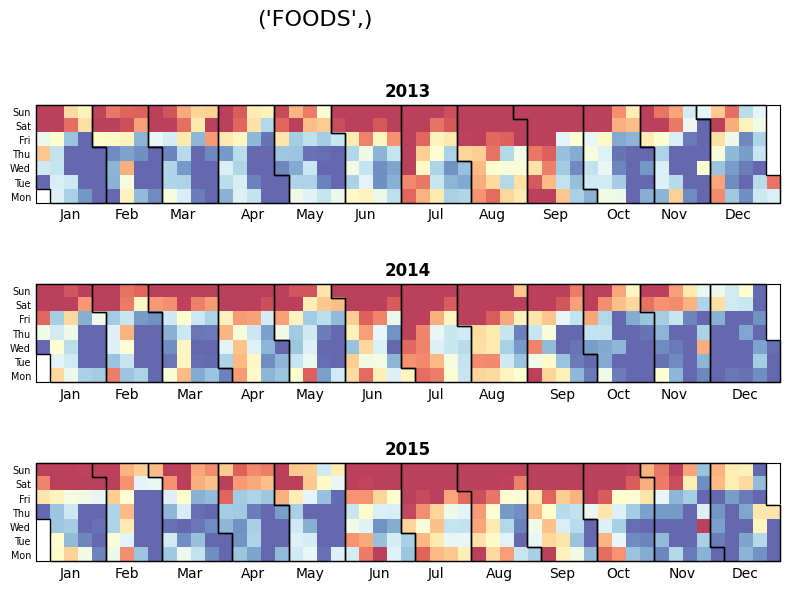

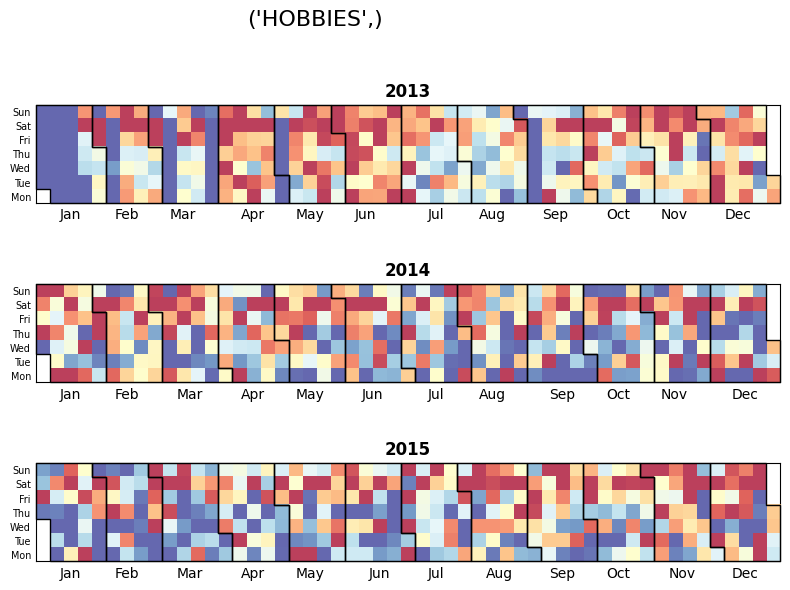

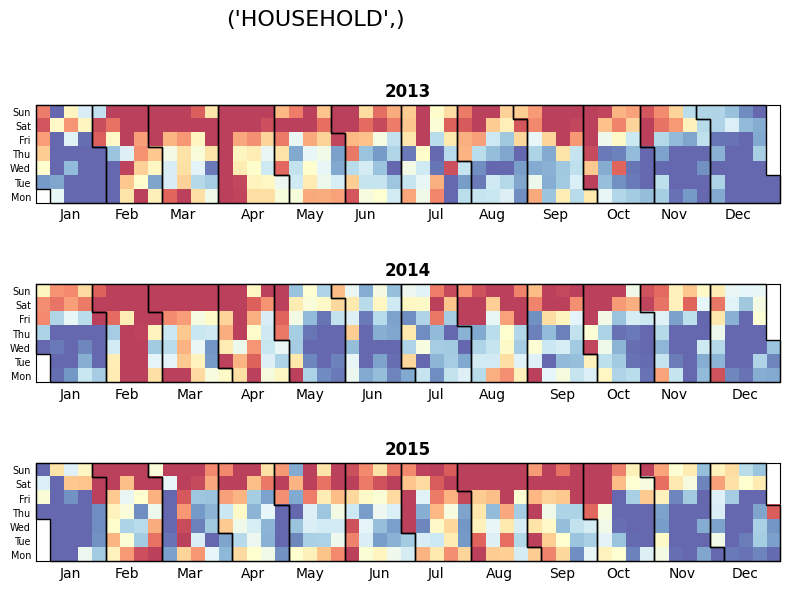

time: 17.6 s (started: 2024-05-05 10:36:48 +00:00)


In [90]:
temp_plot = df_sample.copy()
from sklearn.preprocessing import StandardScaler
sscale = StandardScaler()
# past_sales.index = pd.to_datetime(past_sales.index)
for key, df_group in df_sample.groupby(["CATEGORY"]):
    fig, axes = plt.subplots(3, 1, figsize=(8, 6))
    # items_col = [c for c in df_sample.columns if i i  n c]

    sales2013 = df_group[df_group["DATE"].isin(pd.date_range('31-Dec-2012', periods=371))].groupby("DATE")["SELL"].mean()
    vals = np.hstack(sscale.fit_transform(sales2013.values.reshape(-1, 1)))
    calmap(axes[0], 2013, vals.reshape(53,7).T)

    sales2014 = df_group[df_group["DATE"].isin(pd.date_range('30-Dec-2013', periods=371))].groupby("DATE")["SELL"].mean()
    vals = np.hstack(sscale.fit_transform(sales2014.values.reshape(-1, 1)))
    calmap(axes[1], 2014, vals.reshape(53,7).T)

    sales2015 = df_group[df_group["DATE"].isin(pd.date_range('29-Dec-2014', periods=371))].groupby("DATE")["SELL"].mean()
    vals = np.hstack(sscale.fit_transform(sales2015.values.reshape(-1, 1)))
    calmap(axes[2], 2015, vals.reshape(53,7).T)

    plt.suptitle(key, fontsize=16, x=0.4, y=1.01)
    plt.tight_layout()
    plt.show()

- Food tends to have lower number of purchases as the month goes on. Could this be because people get their paychecks early in the month?
- Household and Hobby items sell much less in January - after the Holiday season is over.
- Cleary weekends are more popular shopping days regardless of the item category.

## Decomposition analysis

In [91]:
from statsmodels.tsa.seasonal import STL, seasonal_decompose

def plot_decomposition(df, start_date = "2011-01-01", end_date = "2016-12-31", period = 7):
    df = df[df["DATE"].between(start_date, end_date)]
    ts = df.set_index("DATE").asfreq("D")["SELL"]

    ma_decompose = seasonal_decompose(ts, model='additive', period=period)
    ma_decompose.plot()
    plt.legend(title = "Additive Seasonal decomposition")

    # ma_decompose = seasonal_decompose(ts, model='multiplicative', period=period)
    # ma_decompose.plot()
    # plt.legend(title = "Multiplicative Seasonal decomposition")

    loess_decompose = STL(ts, seasonal = period).fit()
    loess_decompose.plot()
    plt.legend(title = "LOESS decomposition")
    plt.show()


time: 290 ms (started: 2024-05-05 10:37:46 +00:00)


In [92]:
df_sum_sell_item = df_sample.groupby("ID")["SELL"].sum().sort_values(ascending = False).reset_index()
df_sum_sell_item

ID      SELL
0        FOODS_3_090_CA_3_evaluation  253859.0
1        FOODS_3_586_TX_2_evaluation  195120.0
2        FOODS_3_586_TX_3_evaluation  151862.0
3        FOODS_3_586_CA_3_evaluation  136269.0
4        FOODS_3_090_CA_1_evaluation  128855.0
..                               ...       ...
995  HOUSEHOLD_1_434_CA_3_evaluation   10907.0
996  HOUSEHOLD_1_327_WI_1_evaluation   10895.0
997      FOODS_3_406_WI_1_evaluation   10894.0
998      FOODS_3_329_CA_2_evaluation   10893.0
999    HOBBIES_1_398_CA_1_evaluation   10865.0

[1000 rows x 2 columns]

time: 555 ms (started: 2024-05-05 10:37:47 +00:00)


**Decomposition of top 3 items largest sell and 3 items smallest sell**

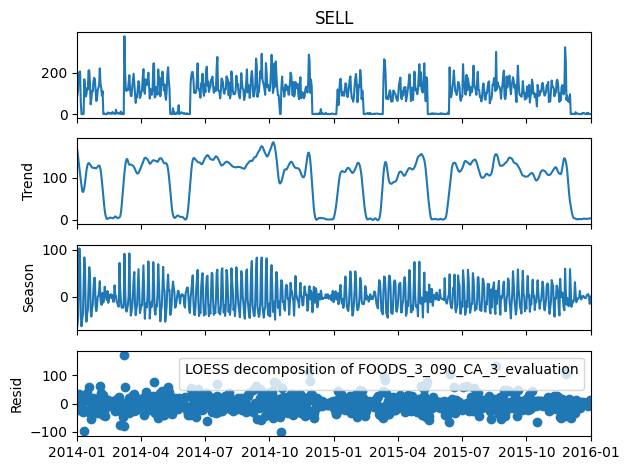

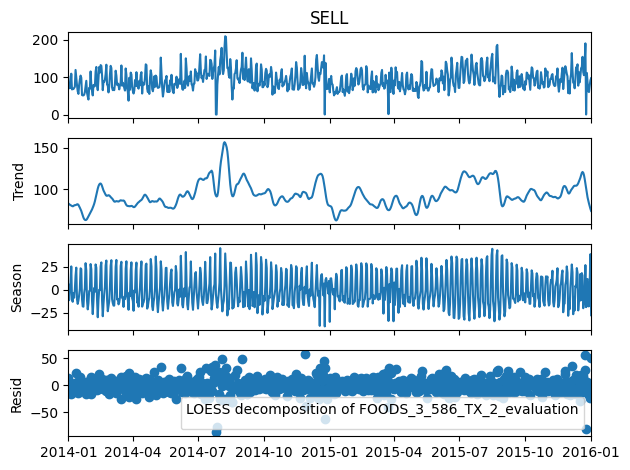

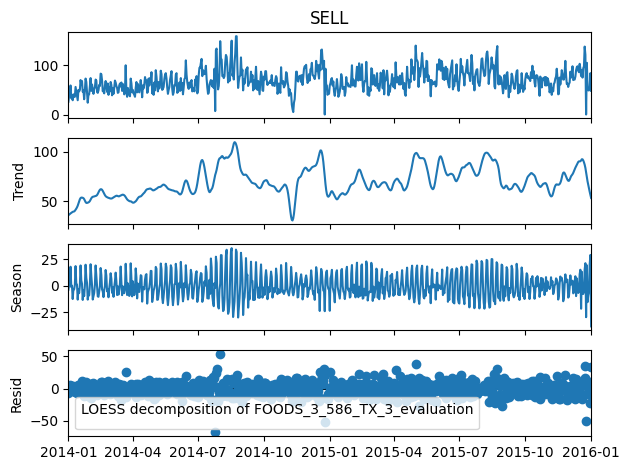

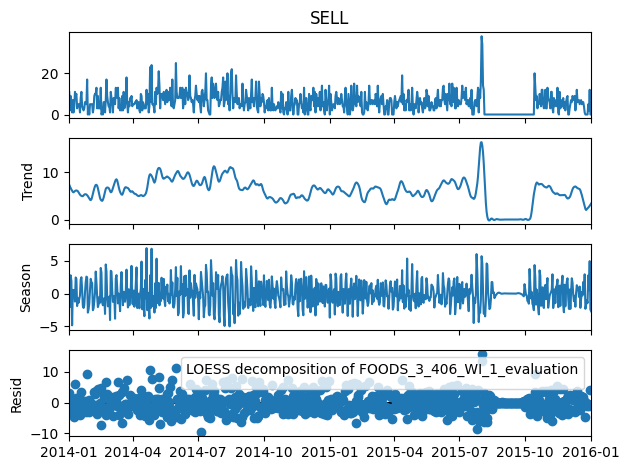

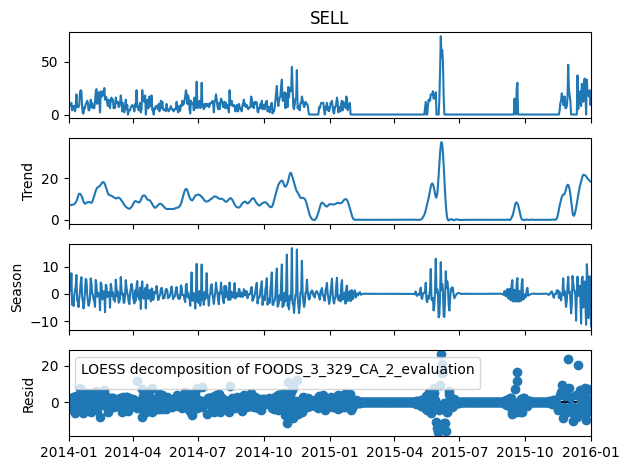

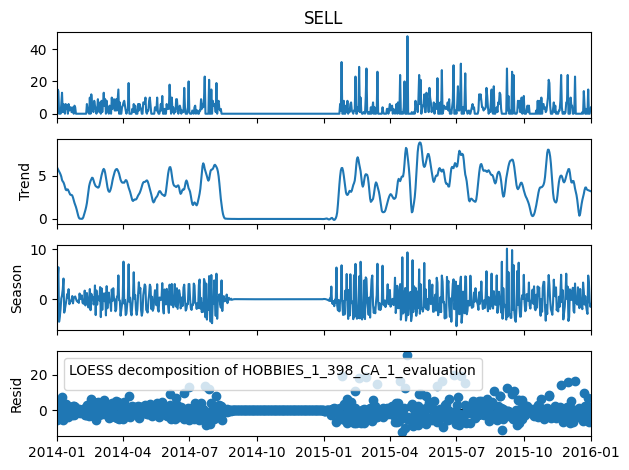

time: 18.7 s (started: 2024-05-05 10:37:47 +00:00)


In [93]:
for item in [*df_sum_sell_item.head(3)["ID"], *df_sum_sell_item.tail(3)["ID"]]:
    df_group = df_sample[
        (df_sample["DATE"].between("2014-01-01", "2016-01-01"))
        & (df_sample["ID"] == item)
    ]
    ts = df_group.set_index("DATE").asfreq("D")["SELL"]

    loess_decompose = STL(ts, seasonal = 7).fit()
    loess_decompose.plot()
    plt.legend(title = "LOESS decomposition of " +item)
    plt.show()

**Overview decomposition of mean total sell data**

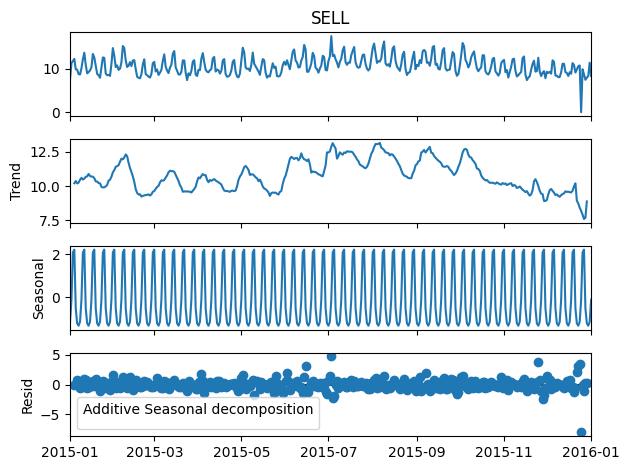

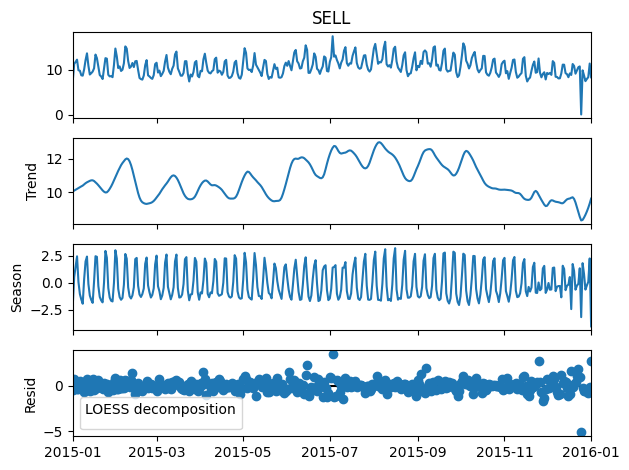

time: 4.81 s (started: 2024-05-05 10:38:06 +00:00)


In [94]:
temp_plot = df_sample.groupby("DATE")["SELL"].mean().reset_index()
plot_decomposition(temp_plot, start_date = "2015-01-01", end_date = "2016-01-01", period = 7)

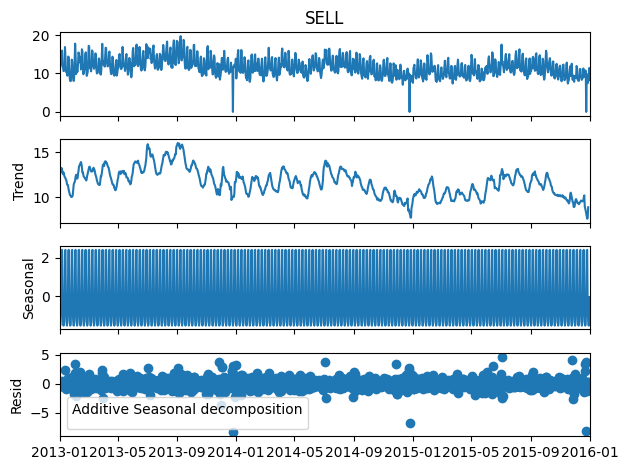

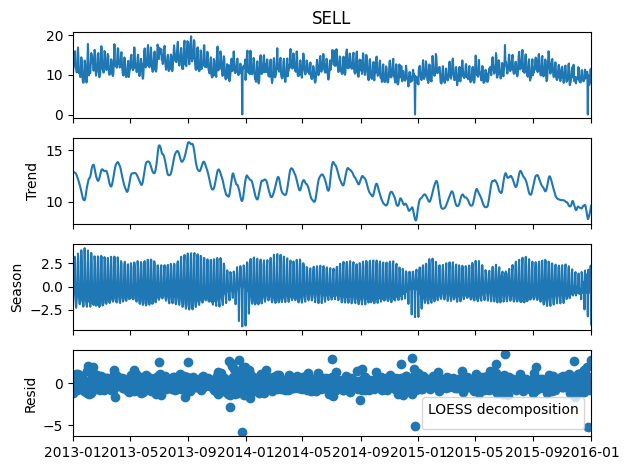

time: 6.03 s (started: 2024-05-05 10:38:11 +00:00)


In [95]:
plot_decomposition(temp_plot, start_date = "2013-01-01", end_date = "2016-01-01", period = 7)

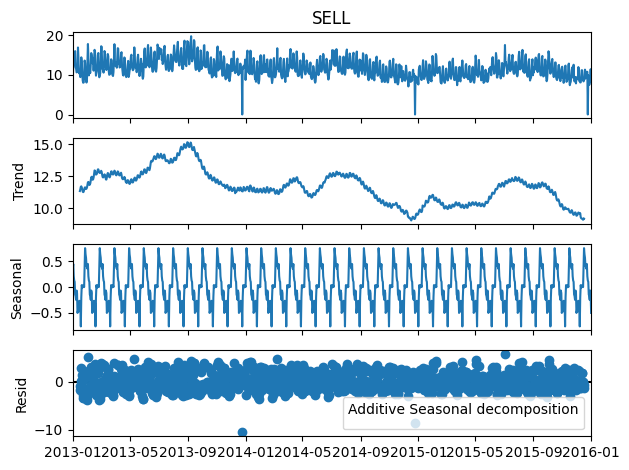

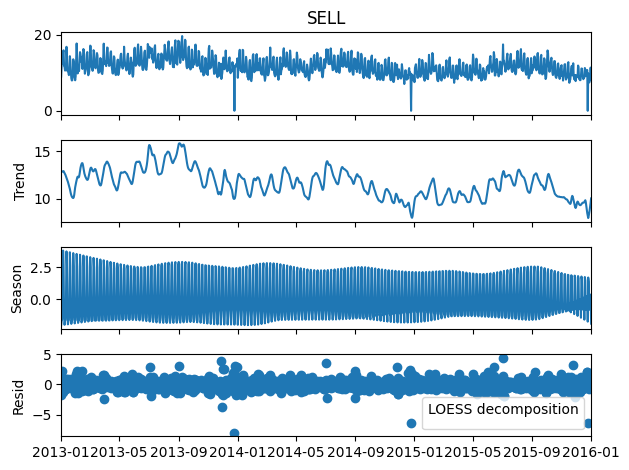

time: 5.73 s (started: 2024-05-05 10:38:17 +00:00)


In [96]:
plot_decomposition(temp_plot, start_date = "2013-01-01", end_date = "2016-01-01", period = 31)

From the decomposition above, there are some point we figure out:

- Data have very strong seasonality with period 1 week (7 days), 1 month. This can help for engineering trend data in each seasons

- In some case of large items, we clearly see that a presentation of cycle with 1 year, that's why I cutoff datetime for smaller data to 1 or 2 year to EDA

- The variance of residual is small and its homoscedasticity overtime. This is a good point that random-noise not impact too much for the trend and seasonality of time-series


Too make sure the residual homoscedasticity I apply Breusch-Pagan Test (one of a hypothesis testing for check homoscedasticity in time-series) on a aggregated sample

Breusch-Pagan test basically uses the principle of calculating half of the explained sum of squares from auxiliary regression. While the auxiliary regression is obtained from the calculation of OLS and residual regression. A more complete theoretical procedure explanation of Breusch-Pagan test can be seen here. This test uses two hypothetical assumptions:

- H0 (Null Hypothesis): Homoscedasticity is present (the residuals are distributed with equal variance)
- HA (Alternative Hypothesis): Heteroscedasticity is present (the residuals are not distributed with equal variance)

In [97]:
from statsmodels.formula.api import ols
temp_plot = df_sample.groupby("DATE")["SELL"].mean().reset_index()
df_model = ols(formula="SELL~DATE", data=temp_plot).fit()

def test_model(col):
    s = []
    for i in col:
        a = [1,i]
        s.append(a)
    return (np.array(s))
exog_ols = test_model(temp_plot['SELL'])
exog_ols

array([[ 1.   , 11.959],
       [ 1.   , 11.848],
       [ 1.   ,  8.886],
       ...,
       [ 1.   , 11.359],
       [ 1.   , 13.183],
       [ 1.   , 14.002]])

time: 27.7 s (started: 2024-05-05 10:38:23 +00:00)


In [98]:
from statsmodels.stats.diagnostic import het_breuschpagan
bp_test = het_breuschpagan(df_model.resid, exog_ols)
print ('LM-test p_value')
print (bp_test[1])

LM-test p_value
0.1291929064578119
time: 122 ms (started: 2024-05-05 10:38:50 +00:00)


p-value > 0.05 a lot -> H0 (null hypothesis) is accecpted -> The resdiual of data is homoscedasticity